In [11]:
try:
    !pip install fxpmath
except:
    pass
# !source /eos/user/m/mhufnage/.venv/bin/activate

import ROOT
import numpy as np
from glob import glob
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from fxpmath import Fxp

# import mpl_scatter_density

# import matplotlib.rcsetup as rcsetup
# print(rcsetup.all_backends)
# print(matplotlib.get_backend())
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

import json
import os,sys
import time

## Custom Packages
from auxiliaryFunctions import *
from calibrationFilesHelper import *
from getXTDataAsPythonDict import *
# from calibrationFilesHelperROOT import *

# import tensorflow

sys.path.insert(1, '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/EventReader/share')
# sys.path.insert(1, '/eos/user/m/mhufnage/SWAN_projects/XTalk/')



Defaulting to user installation because normal site-packages is not writeable


# Load files and Paths

In [3]:
# MC
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/source/EventReader/share/file002.npz' 
# dataset     = np.load(filename,allow_pickle=True) # npz file contains arrays of dicts.

# Data
resultFiles     = ['results_analysis_cluster.npz', 'results_analysis_711roi.npz']
supTitleString  = ['TopoCluster', '7x11 EMB2 ROI']
confFiles       = ['conf_analysis_cluster.npz','conf_analysis_711.npz']
clusNames       = ['clusters', '711_roi']
eventsBlockList = [-99999999]

# datasetPath = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_offlCalib/*'
# datasetPath ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getOFCandRamp_new/dataMinBias_getOFCandRamp_part*.npz'
# datasetPath ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getOFCandRamp/*'#dataMinBias_getOFCandRamp_part*.npz
# datasetPath ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getDSPThrs/dataMinBias_getDSPThrs_part*.npz'
# datasetPath ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_janFix/dataMinBias_janFix_part*.npz'
datasetPath ='/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/dumpedData/zeeMinBias_part0.npz'

# Result file to analysis
# resultFileAlias   = 'flipped_timeThres'
# resultFileAlias   = 'timeThres'
# resultFileAlias     = 'onlineCalibDSP'
resultFileAlias     = 'OFCdumperSigmaThr'
# resultFiles         = 'offlineCalib'

# Helper
path        = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/EventReader/share/'
fDict       = open(path+'dictCaloByLayer.json')
caloDict    = json.load(fDict)

calibPathLAr = '/eos/user/m/mhufnage/scripts_lxplus/calibration/calib_LAr/'

print("constants loaded succesfully.")

constants loaded succesfully.


## Calibration constants:  \*.root $\rightarrow$ *.npz
- Run to generate the \*.npz files for the calibration constants, from their root files.

In [3]:
# from calibrationFilesHelperROOT import *

# # OFC
# print("OFC...")
# fileName = calibPathLAr+'LArCalib_OFC_r329542.root'
# ofc_dict  = readOFCRootFile(fileName)

# # PEDESTALS
# print("PED...")
# fileName = calibPathLAr+'LArCalib_ped_r329542.root'
# ped_dict  = readPEDRootFile(fileName)

# # MPMC
# print("MPMC...")
# fileName = calibPathLAr+'LArCalib_mphysovermcalib329542_athena22044.root'
# mpmc_dict  = readMPMCRootFile(fileName)

# # UAMEV
# print("UAMEV...")
# fileName = calibPathLAr+'LArCalib_dac2ua-ua2mev329542_athena22044.root'
# uamev_dict = readUAMEVRootFile(fileName)

# # RAMPS
# fileName = calibPathLAr+'LArCalib_ramp329542_athena22044.root'
# ramps_dict = readRAMPSRootFile(fileName)

## Load calibration constants from \*.npz
- Run to only load the calibration constants to memory.

In [3]:
ofc_dict = np.load('calibration/OFC_dict.npz',allow_pickle=True )['OFC'].tolist()
ped_dict = np.load('calibration/PED_dict.npz',allow_pickle=True )['PED'].tolist()
mpmc_dict = np.load('calibration/MPMC_dict.npz',allow_pickle=True )['MPMC'].tolist()
uamev_dict = np.load('calibration/UAMEV_dict.npz',allow_pickle=True )['UAMEV'].tolist()
ramps_dict = np.load('calibration/RAMPS_dict.npz',allow_pickle=True )['RAMPS'].tolist()

# A.0) Time Resolution Analysis (Online)

In [4]:
resultFileAlias = 'timeResolutionAnalysis'
# datasetPath = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_vertexAnalysis/*'
datasetPath ='/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/dumpedData/zeeMinBias_part0.npz'


start = time.time()
 
#---------------------------------------------
#--------- Data Analysis conditions ---------
#---------------------------------------------
bPedFromDB          = True # Ped from DB (TRUE) or from Script (FALSE)
bFullWindows        = False # use only full windows from clusters
bDoOfflineCalib     = False
el_thrs             = [0] # GeV
cell_ene_thr        = 500 # MeV (cut from every cell)
nCellsChEta         = 5
nCellsChPhi         = 5
nCellsRawChEta      = 5
nCellsRawChPhi      = 5
# clusNames           = ['711_roi', 'clusters'] #'clusters'
clusNames           = ['clusters']#,'711_roi'] #'clusters'
# calibTypes          = ['database', 'typical'] #'database'#'dumper' #'typical' # or 
calibTypes          = ['dumper'] # name of the type of calibration, to differentiate from offline or database (analysis/debug) #'database'#'database' #'typical' # or 
layers              = caloDict["Layer"][0:4]
#---------------------------------------------
#------------- DSP conditions #------------- < Not getting nice results from quantization. Ignore those *Quant* boolean options. >
#---------------------------------------------
typeThreshold       = 'EneThr'#'fixedValue'#'EneThr'#'NoiseSigma'#
bAbsDSPE1           = True  # use abs(E) to get E1, and compare to E_thr
bPerfomQuant        = False # ~X~ apply the quantized form of energy and time estimation (like DSP)
applyCteQuant       = False # ~X~ True # apply quantization to the alpha, beta, Pa, Pb. If False, use likeDSP function, but full precision constants.
reorderSamp         = False # ~X~ reorder samples like-dsp

if bPerfomQuant:
    na, nb, n           = getLArDSPnFactor(ofc_dict, ped_dict, ramps_dict,reorderSamples=reorderSamp) # n factor to convert Float to Fixed point Integer.
    print('na={}, nb={} and n={}'.format(na,nb,n))

#---------------------------------------------
#-------------- Data Reading -----------------
#---------------------------------------------

fileNames       = glob(datasetPath)


for calibType in calibTypes:
    print('Calibration type: {}'.format(calibType))
    for el_thr in el_thrs:
        print('Electron pt cut: {} GeV'.format(el_thr))
        for clusName in clusNames:
            elec_counter    = 0 # counter of electrons in dataset
            print('Processing cluster: {}'.format(clusName))

            analysis   = [
                        # Particle / event
                        'datasetElectronIndex',

                        # Channel
                        'digitsWindow',
                        'digitsWindowSize',
                        'channelEnergyWindow',
                        'channelTimeWindow', 
                        # 'channelInfoWindow',
                        'channelBarrel_ec',
                        'channelPos_neg',
                        'channelFeedthrough',
                        'channelSlot', 
                        'channelNumber',
                        'channelIdWindow',
                        'channelGainWindow',
                        'channelEtaWindow',
                        'channelPhiWindow',
                        'channelEffSigmaWindow',

                        # Online Calib
                        'channelDSPThrWindow',
                        'channelRamps0Window',
                        'channelRamps1Window',
                        'channelPedWindow',
                        'channelPedDictWindow',
                        
                        # Offline calib
                        # 'channelShapeWindow',
                        # 'channelMinBiasAvgWindow',
                        # 'channelOfflHVWindow',
                        # 'channelEneRescWindow',

                        # Estimated values (using calib. constants)
                        'AWindow',
                        'tauDSPWindow',  # online (DSP) calibration
                        'EDSPCalibWindow',   # online (DSP) calibration
                        'tauDSPThrDiffWindow',
                        # 'eneDSPerrorCalib',
                        # 'tauDSPerrorCalib',
                        # 'eneOfflineWindow',
                        # 'tauOfflineWindow',

                        'rawChEnergyWindow',
                        'rawChTimeWindow',                  
                        'rawChInfoWindow',
                        'rawChIdWindow',
                        'rawChGainWindow',
                        'rawChDSPThrWindow',
                        'rawChEtaWindow',
                        'rawChPhiWindow',
                        'rawChProvWindow'
                        ]

            results                 = {key:{key1:[] for key1 in analysis} for key in layers}
            # Particle
            results['electron']     = {'datasetElectronIndex': [],'electronPt': [],'electronEta': [],'electronPhi': [],'electronVertexZ': [],'electronNClus': [],'electronClusSizes': []} # Electron data

            for file in fileNames:
                print(file)
                dataset     = np.load(file, allow_pickle=True)

                for evtn, ev in enumerate(dataset['dataset']): # for each event...
                    if (ev['eventNumber'][0] in eventsBlockList):
                        print('Ignoring blocked event {}.'.format(ev['eventNumber']))
                        continue
                    # if (evtn%100) == 0:
                    #     print("Event {}...".format(evtn))
                    # if evtn > evt_lim:
                    #     break

                    for elec in ev['electrons'].keys(): # for each electron in this event...
                #         print(ev['electrons'][elec]['pt'])
                        if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
                            continue
                        if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                            continue
                        
                        elec_counter+=1
                        elecClusSizes   = []

                        clusloop        = ev['electrons'][elec][clusName]

                        elecPt          = (ev['electrons'][elec]['pt'])
                        elecEta         = (ev['electrons'][elec]['eta'])
                        elecPhi         = (ev['electrons'][elec]['phi'])
                        elecVtxZ        = (ev['electrons'][elec]['vertexZ'])
                        elecNClus       = len(ev['electrons'][elec][clusName])

                        for clus in clusloop.keys(): # for each cluster associated to that electron...
                            elecClusSizes.append(len(ev['electrons'][elec][clusName][clus]['cells']['index'][0]))

                        # print('elecPt: ',elecPt)
                        # print('elecEta: ',elecEta)
                        # print('elecPhi: ',elecPhi)
                        # print('elecVtxZ: ',elecVtxZ)
                        # print('elecNClus: ',elecNClus)

                        results['electron']['electronPt']           .append(elecPt)
                        results['electron']['electronEta']          .append(elecEta)
                        results['electron']['electronPhi']          .append(elecPhi)
                        results['electron']['electronVertexZ']      .append(elecVtxZ)
                        results['electron']['electronNClus']        .append(elecNClus)
                        results['electron']['electronClusSizes']    .append(elecClusSizes)
                        results['electron']['datasetElectronIndex'] .append(elec_counter)
                        
                        for clus in clusloop.keys(): # for each cluster associated to that electron...                         

                            for layern, layer in enumerate(layers):
                                
                                # get list indexes that match to current sampling
                                channelLayerIndexes     = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0], layer) 
                                rawChannelLayerIndexes  = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'][0], layer)

                                # is that layer empty for RAWCh or Ch? skip
                                if (len(channelLayerIndexes) == 0 ) or (len(rawChannelLayerIndexes)==0):
                                    continue

                                ###################     ###############
                                ## Channel + Digits  +  ## RawChannel #
                                ###################     ###############
                                windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                                    ev['electrons'][elec][clusName][clus]['channels']['energy'],
                                    ev['electrons'][elec][clusName][clus]['channels']['index'],
                                    ev['electrons'][elec][clusName][clus]['channels']['eta'],
                                    ev['electrons'][elec][clusName][clus]['channels']['phi'],
                                    ev['electrons'][elec][clusName][clus]['channels']['sampling'],
                                    nCellsChEta, 
                                    nCellsChPhi, 
                                    ev['electrons'][elec][clusName][clus]['channels']['deta'],
                                    ev['electrons'][elec][clusName][clus]['channels']['dphi'],
                                    layer=layer)
                                

                                windowIndexesRawCh, layerIndexesRawCh = getCellsInWindowCustomSize(
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['index'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['eta'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['phi'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'],
                                    nCellsRawChEta, 
                                    nCellsRawChPhi, 
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['deta'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['dphi'],
                                    layer=layer)

                                # any of the windows aren't full??
                                if bFullWindows:
                                    if (len(windowIndexesCh) != (nCellsChEta*nCellsChPhi)) or (len(windowIndexesRawCh) != (nCellsRawChEta*nCellsRawChPhi)):
                                        continue

                                # if they belong to the same calo object and have the same size, they MUST have the same cells, because the dumper rule is the same.
                                # BUT, they cells aren't stored at the same order.
                                # First, lets check if their cells, in the current layer, are the same!
                                # print("Ok, both windows are full, lets check their cells. RawCh={}, Ch={}".format(len(windowIndexesRawCh),len(windowIndexesCh)))
                                digits              = np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)         [windowIndexesCh] .tolist()
                                digitsSize          = len (np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)    [windowIndexesCh] .tolist())
                                channelEnergy       = np.array(ev['electrons'][elec][clusName][clus]['channels']['energy'][0],dtype=object)         [windowIndexesCh] .tolist()
                                channelTime         = np.array(ev['electrons'][elec][clusName][clus]['channels']['time'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelInfo         = listOfListsToArrayOfArrays(np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)         [windowIndexesCh] .tolist())
                                channelId           = np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)      [windowIndexesCh] .tolist()
                                channelSampling     = np.array(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelEta          = np.array(ev['electrons'][elec][clusName][clus]['channels']['eta'][0],dtype=object)            [windowIndexesCh] .tolist()
                                channelPhi          = np.array(ev['electrons'][elec][clusName][clus]['channels']['phi'][0],dtype=object)            [windowIndexesCh] .tolist()
                                channelGain         = np.array(ev['electrons'][elec][clusName][clus]['channels']['gain'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelEffSigma     = np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)       [windowIndexesCh] .tolist()
                                # channelNoise        = np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)          [windowIndexesCh] .tolist()
                                channelDSPThr       = np.array(ev['electrons'][elec][clusName][clus]['channels']['DSPThreshold'][0],dtype=object)   [windowIndexesCh] .tolist()
                                channelOFCa         = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCa'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelOFCb         = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCb'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelRamps0       = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV0'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelRamps1       = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV1'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelLArPed       = np.array(ev['electrons'][elec][clusName][clus]['channels']['LArDB_Pedestal'][0],dtype=object) [windowIndexesCh] .tolist()
                                channelTimeOffset   = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCTimeOffset'][0],dtype=object)  [windowIndexesCh] .tolist()
                                channelEffSigma     = np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelNoise        = np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)          [windowIndexesCh] .tolist()
                                # channelShape        = np.array(ev['electrons'][elec][clusName][clus]['channels']['Shape'][0],dtype=object)          [windowIndexesCh] .tolist()
                                if bDoOfflineCalib:
                                    channelMinBiasAvg   = np.array(ev['electrons'][elec][clusName][clus]['channels']['MinBiasAvg'][0],dtype=object)     [windowIndexesCh] .tolist()
                                    channelOfflHV       = np.array(ev['electrons'][elec][clusName][clus]['channels']['OfflHVScale'][0],dtype=object)    [windowIndexesCh] .tolist()
                                    channelEneResc      = np.array(ev['electrons'][elec][clusName][clus]['channels']['OfflEneRescaler'][0],dtype=object)[windowIndexesCh] .tolist()

                                rawChEnergyDSP    = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)      # this is not the amplitude, it is the E_dsp
                                rawChTimeDSP      = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['time'][0],dtype=object)          
                                rawChInfo         = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['chInfo'][0],dtype=object)        
                                rawChId           = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['channelId'][0],dtype=object)     
                                rawChDSPThr       = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['DSPThreshold'][0],dtype=object) 
                                rawChEta          = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['eta'][0],dtype=object) 
                                rawChPhi          = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['phi'][0],dtype=object)
                                rawChProv         = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['LAr_Provenance'][0],dtype=object)

                                # Selection of Pedestal (DB or Script)
                                if not(bPedFromDB):
                                    peds = [] #testing
                                    gainsInt = getGainInteger(channelGain)
                                if bPedFromDB:
                                    peds = channelLArPed
                                
                                # The cells that came from Window algorithm are not the same when comparing RawCh and Digits.
                                # For that, we will select the same Digits cells set, based on the HWID, inside the Raw Channel cluster cells set. 
                                mirrorIndexes = []
                                for k, hwid in enumerate(channelId):
                                    position        = np.where(rawChId[layerIndexesRawCh] == hwid)[0][0]
                                    mirrorIndexes.append(position) # its the window mirrored indexes for RawCh
                                    if not(bPedFromDB):
                                        cell_dict_ped   = getLArChannelPED  (hwid, ped_dict  )
                                        peds.append(cell_dict_ped['ped'][0][gainsInt[k]]) # picking up the right gain weights
                                

                                # do the software DSP estimation  
                                Awin, tauDSPWin, EDSPWin, tauDSPWin_thrDiff = DSPCalibSamplesInCluster(channelId, digits, channelGain, peds, channelOFCa, channelOFCb, channelRamps0, channelRamps1, channelDSPThr, channelTimeOffset,  thresholdMode=typeThreshold, bDoAbsE1=bAbsDSPE1)
                                # add here the offline calibration (not working yet)
                                if bDoOfflineCalib:
                                    offl_pileupOffset   = 0 # getOfflinePileUpOffset(evt_lumiblock, lumiPerBCIDVector, evt_bcid, minBiasAvgs, ofcas, shapes)
                                    offl_tauOffset      = 0
                                    offl_ene, offl_tau  = offlineCalibInCluster(EDSPWin, tauDSPWin, channelOfflHV, channelEneResc, offl_pileupOffset, offl_tauOffset)

                                # Save variables to posterior analysis
                                results[layer]['datasetElectronIndex']      .append(elec_counter        )

                                results[layer]['digitsWindow']              .append(digits              )
                                results[layer]['digitsWindowSize']          .append(digitsSize          )
                                results[layer]['channelEnergyWindow']       .append(channelEnergy       )
                                results[layer]['channelTimeWindow']         .append(channelTime         )
                                # results[layer]['channelInfoWindow']         .append(channelInfo         )
                                results[layer]['channelIdWindow']           .append(channelId           )
                                results[layer]['channelGainWindow']         .append(channelGain         )
                                results[layer]['channelEffSigmaWindow']     .append(channelEffSigma     )
                                # results[layer]['channelNoiseWindow']        .append(channelNoise        )
                                results[layer]['channelDSPThrWindow']       .append(channelDSPThr       )
                                results[layer]['channelEtaWindow']          .append(channelEta          )
                                results[layer]['channelPhiWindow']          .append(channelPhi          )
                                results[layer]['channelRamps0Window']       .append(channelRamps0       )
                                results[layer]['channelRamps1Window']       .append(channelRamps1       )
                                results[layer]['channelPedWindow']          .append(channelLArPed       )
                                results[layer]['channelPedDictWindow']      .append(peds                )

                                if len(channelInfo)==0:
                                    results[layer]['channelBarrel_ec']          .append([]                  )
                                    results[layer]['channelPos_neg']            .append([]                  )
                                    results[layer]['channelFeedthrough']        .append([]                  )
                                    results[layer]['channelSlot']               .append([]                  )
                                    results[layer]['channelNumber']             .append([]                  )                                    
                                else:
                                    results[layer]['channelBarrel_ec']          .append(channelInfo[:,0]    )
                                    results[layer]['channelPos_neg']            .append(channelInfo[:,1]    )
                                    results[layer]['channelFeedthrough']        .append(channelInfo[:,2]    )
                                    results[layer]['channelSlot']               .append(channelInfo[:,3]    )
                                    results[layer]['channelNumber']             .append(channelInfo[:,4]    )
                                    

                                results[layer]['AWindow']            .append(Awin               )
                                results[layer]['tauDSPWindow']       .append(tauDSPWin          )
                                results[layer]['EDSPCalibWindow']    .append(EDSPWin            )
                                results[layer]['tauDSPThrDiffWindow'].append(tauDSPWin_thrDiff  )

                                results[layer]['rawChEnergyWindow']  .append(rawChEnergyDSP [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChTimeWindow']    .append(rawChTimeDSP   [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChInfoWindow']    .append(rawChInfo      [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChIdWindow']      .append(rawChId        [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChDSPThrWindow']  .append(rawChDSPThr    [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChEtaWindow']     .append(rawChEta       [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChPhiWindow']     .append(rawChPhi       [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChProvWindow']    .append(rawChProv      [layerIndexesRawCh][mirrorIndexes])

                        # print('elecClusSizes: ', elecClusSizes)
                #----------------------- TESTE AREA -----------------------
                # break # exiting test loop here!
                #--------------------------------------------------------------
                
            confDict = {
                'el_thr': el_thr,
                'elec_counter':elec_counter,
                'nCellsChEta': nCellsChEta,
                'nCellsChPhi': nCellsChPhi,
                'nCellsRawChEta': nCellsRawChEta,
                'nCellsRawChPhi': nCellsRawChPhi,
                'datasetPath': datasetPath,
                'calibType': calibType,
                'bFullWindows': bFullWindows,
                'bPedFromDB':   bPedFromDB,
                'bDoOfflineCalib': bDoOfflineCalib,
                'typeThreshold': typeThreshold,
                'bAbsDSPE1': bAbsDSPE1,
                'bPerfomQuant': bPerfomQuant,
                'applyCteQuant': applyCteQuant,
                'reorderSamp': reorderSamp,
                'fileNames': fileNames
            }
            
            # print(results.keys())
            
            np.savez('calibration/vertex_results_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr),**results)
            np.savez('calibration/vertex_conf_analysis_{}_{}_{}_eCut{}GeV.npz'.format(resultFileAlias, clusName,calibType,el_thr),conf=confDict)
end = time.time()

print("Total running time: {:.2f} minutes.".format((end - start)/60))


Calibration type: dumper
Electron pt cut: 0 GeV
Processing cluster: clusters
/eos/user/m/mhufnage/ALP_project/root/user.mhufnage.data17_13TeV_dumpedEventReader_TagAndProbe_v01_XYZ.root.tgz/dumpedData/zeeMinBias_part0.npz
Total running time: 0.03 minutes.


(array([200.,   7.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([  109.24459839,  6897.9240448 , 13686.60349121, 20475.28293762,
        27263.96238403, 34052.64183044, 40841.32127686, 47630.00072327,
        54418.68016968, 61207.35961609, 67996.0390625 ]),
 <BarContainer object of 10 artists>)

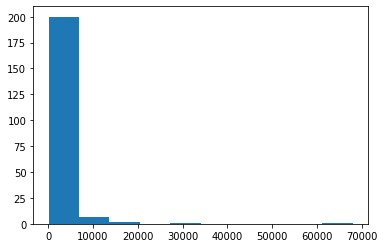

In [12]:
plt.hist(list(np.concatenate(results['EMB2']['channelEnergyWindow']).flat))
plt.show()

# A) Calibration analysis: Digits and RawChannels

In [4]:
# resultFileAlias = '_alfa32_Etau32' #OK
# resultFileAlias = '_alfaNQuant_Etau32'
# resultFileAlias = '_alfa32_EtauNQuant'
# resultFileAlias = '_alfaNQuant_EtauNQuant'
# resultFileAlias = '_alfaNQuant_Etau32'
# resultFileAlias = '_OfflineCalib'
# resultFileAlias = '_ONLINECALIBTEST'

resultFileAlias = '_ONLINECALIBTESTNEWPedScriptNew'
# datasetPath = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_offlCalib/*'
datasetPath = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_offlineConstants_fixPed/*'

# chid = dataset['dataset'][1]['electrons']['el_0']['clusters']['cl_0'][cellInfoName]['channelId'][0]
import time

start = time.time()
evt_lim = 15

bPedFromDB          = False # Ped from DB (TRUE) or from Script (FALSE)
bFullWindows        = False # use only full windows from clusters
bDoOfflineCalib     = False
#------------- DSP conditions #------------- < Not getting nice results from quantization. Ignore those *Quant* boolean options. >
typeThreshold       = 'EneThr'#'fixedValue'#'EneThr'#'NoiseSigma'#
bAbsDSPE1           = True #use abs(E) to get E1, and compare to E_thr
bPerfomQuant        = False # apply the quantized form of energy and time estimation (like DSP)
applyCteQuant       = False # True # apply quantization to the alpha, beta, Pa, Pb. If False, use likeDSP function, but full precision constants.
reorderSamp         = False # reorder samples like-dsp

if bPerfomQuant:
    na, nb, n           = getLArDSPnFactor(ofc_dict, ped_dict, ramps_dict,reorderSamples=reorderSamp) # n factor to convert Float to Fixed point Integer.
    print('na={}, nb={} and n={}'.format(na,nb,n))
# na = n
# nb = n
#--------------------------------------------
el_thrs             = [10] # GeV
nCellsChEta         = 5
nCellsChPhi         = 5
nCellsRawChEta      = 5
nCellsRawChPhi      = 5
# clusNames           = ['711_roi', 'clusters'] #'clusters'
clusNames           = ['clusters']#,'711_roi'] #'clusters'
# calibTypes          = ['database', 'typical'] #'database'#'dumper' #'typical' # or 
calibTypes          = ['dumper'] # name of the type of calibration, to differentiate from offline or database (analysis/debug) #'database'#'database' #'typical' # or 
layers              = caloDict["Layer"][0:4]
 
fileNames       = glob(datasetPath)

elec_counter    = 0 # counter of electrons in dataset
for calibType in calibTypes:
    print('Calibration type: {}'.format(calibType))
    for el_thr in el_thrs:
        print('Electron pt cut: {} GeV'.format(el_thr))
        for clusName in clusNames:
            print('Processing cluster: {}'.format(clusName))

            analysis   = [
                        'digitsWindow',
                        'digitsWindowSize',
                        'channelEnergyWindow',
                        'channelTimeWindow', 
                        'channelInfoWindow',
                        'channelIdWindow',
                        'channelGainWindow',
                        'channelEtaWindow',
                        'channelPhiWindow',
                        'channelEffSigmaWindow',
                        'channelNoiseWindow',

                        # Online Calib
                        'channelDSPThrWindow',
                        'channelRamps0Window',
                        'channelRamps1Window',
                        'channelPedWindow',
                        'channelPedDictWindow',

                        
                        # Offline calib
                        'channelShapeWindow',
                        'channelMinBiasAvgWindow',
                        'channelOfflHVWindow',
                        'channelEneRescWindow',

                        # Estimated values (using calib. constants)
                        'AWindow',
                        'tauDSPWindow',  # online (DSP) calibration
                        'EDSPCalibWindow',   # online (DSP) calibration
                        'tauDSPThrDiffWindow',
                        'eneDSPerrorCalib',
                        'tauDSPerrorCalib',
                        'eneOfflineWindow',
                        'tauOfflineWindow',

                        'rawChEnergyWindow',
                        'rawChTimeWindow',                  
                        'rawChInfoWindow',
                        'rawChIdWindow',
                        'rawChGainWindow',
                        'rawChDSPThrWindow',
                        'rawChEtaWindow',
                        'rawChPhiWindow',
                        'rawChProvWindow'
                        ]

            results              = {key:{key1:[] for key1 in analysis} for key in layers}
            results[clusName]    = {'pt':[],'eta':[],'phi':[]} # Cluster and ROI data

            for file in fileNames:
                print(file)
                dataset     = np.load(file, allow_pickle=True)

                for evtn, ev in enumerate(dataset['dataset']): # for each event...
                    # print("Event number: {}".format(ev['eventNumber']))
                    if (ev['eventNumber'][0] in eventsBlockList):
                        print('Ignoring blocked event {}.'.format(ev['eventNumber']))
                        continue
                    # if (evtn%100) == 0:
                    #     print("Event {}...".format(evtn))
                    # if evtn > evt_lim:
                    #     break

                    for elec in ev['electrons'].keys(): # for each electron in this event...
                #         print(ev['electrons'][elec]['pt'])
                        if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
                            continue
                        if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                            continue
                        
                        elec_counter+=1
                        clusloop = ev['electrons'][elec][clusName]

                        for clus in clusloop.keys(): # for each cluster associated to that electron...
                            
                            # results[clusName]['pt'].append(ev['electrons'][elec][clusName][clus]['pt'])
                            # results[clusName]['eta'].append(ev['electrons'][elec][clusName][clus]['eta'])
                            # results[clusName]['phi'].append(ev['electrons'][elec][clusName][clus]['phi'])

                            for layern, layer in enumerate(layers):

                                channelLayerIndexes     = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0], layer) # get list indexes that match to current sampling
                                rawChannelLayerIndexes  = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'][0], layer)

                                # is that layer empty for RAWCh or Ch? skip
                                if (len(channelLayerIndexes) == 0 ) or (len(rawChannelLayerIndexes)==0):
                                    continue

                                ###################     ###############
                                ## Channel + Digits  +  ## RawChannel #
                                ###################     ###############
                                windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                                    ev['electrons'][elec][clusName][clus]['channels']['energy'],
                                    ev['electrons'][elec][clusName][clus]['channels']['index'],
                                    ev['electrons'][elec][clusName][clus]['channels']['eta'],
                                    ev['electrons'][elec][clusName][clus]['channels']['phi'],
                                    ev['electrons'][elec][clusName][clus]['channels']['sampling'],
                                    nCellsChEta, 
                                    nCellsChPhi, 
                                    ev['electrons'][elec][clusName][clus]['channels']['deta'],
                                    ev['electrons'][elec][clusName][clus]['channels']['dphi'],
                                    layer=layer)
                                

                                windowIndexesRawCh, layerIndexesRawCh = getCellsInWindowCustomSize(
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['index'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['eta'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['phi'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'],
                                    nCellsRawChEta, 
                                    nCellsRawChPhi, 
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['deta'],
                                    ev['electrons'][elec][clusName][clus]['rawChannels']['dphi'],
                                    layer=layer)

                                # any of the windows aren't full??
                                if bFullWindows:
                                    if (len(windowIndexesCh) != (nCellsChEta*nCellsChPhi)) or (len(windowIndexesRawCh) != (nCellsRawChEta*nCellsRawChPhi)):
                                        continue
                                
                                # if they belong to the same calo object and have the same size, they MUST have the same cells, because the dumper rule is the same.
                                # BUT, they cells aren't stored at the same order.
                                # First, lets check if their cells, in the current layer, are the same!
                                # print("Ok, both windows are full, lets check their cells. RawCh={}, Ch={}".format(len(windowIndexesRawCh),len(windowIndexesCh)))
                                digits              = np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)         [windowIndexesCh] .tolist()
                                digitsSize          = len (np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)    [windowIndexesCh] .tolist())
                                channelEnergy       = np.array(ev['electrons'][elec][clusName][clus]['channels']['energy'][0],dtype=object)         [windowIndexesCh] .tolist()
                                channelTime         = np.array(ev['electrons'][elec][clusName][clus]['channels']['time'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelInfo         = np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)         [windowIndexesCh] .tolist()
                                channelId           = np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)      [windowIndexesCh] .tolist()
                                channelSampling     = np.array(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelEta          = np.array(ev['electrons'][elec][clusName][clus]['channels']['eta'][0],dtype=object)            [windowIndexesCh] .tolist()
                                channelPhi          = np.array(ev['electrons'][elec][clusName][clus]['channels']['phi'][0],dtype=object)            [windowIndexesCh] .tolist()
                                channelGain         = np.array(ev['electrons'][elec][clusName][clus]['channels']['gain'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelEffSigma     = np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelNoise        = np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)          [windowIndexesCh] .tolist()
                                channelDSPThr       = np.array(ev['electrons'][elec][clusName][clus]['channels']['DSPThreshold'][0],dtype=object)   [windowIndexesCh] .tolist()
                                channelOFCa         = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCa'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelOFCb         = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCb'][0],dtype=object)           [windowIndexesCh] .tolist()
                                channelRamps0       = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV0'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelRamps1       = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV1'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelLArPed       = np.array(ev['electrons'][elec][clusName][clus]['channels']['LArDB_Pedestal'][0],dtype=object) [windowIndexesCh] .tolist()
                                channelTimeOffset   = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCTimeOffset'][0],dtype=object)  [windowIndexesCh] .tolist()
                                channelEffSigma     = np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)       [windowIndexesCh] .tolist()
                                channelNoise        = np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)          [windowIndexesCh] .tolist()
                                # channelShape        = np.array(ev['electrons'][elec][clusName][clus]['channels']['Shape'][0],dtype=object)          [windowIndexesCh] .tolist()
                                if bDoOfflineCalib:
                                    channelMinBiasAvg   = np.array(ev['electrons'][elec][clusName][clus]['channels']['MinBiasAvg'][0],dtype=object)     [windowIndexesCh] .tolist()
                                    channelOfflHV       = np.array(ev['electrons'][elec][clusName][clus]['channels']['OfflHVScale'][0],dtype=object)    [windowIndexesCh] .tolist()
                                    channelEneResc      = np.array(ev['electrons'][elec][clusName][clus]['channels']['OfflEneRescaler'][0],dtype=object)[windowIndexesCh] .tolist()

                                rawChEnergyDSP    = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)      # this is not the amplitude, it is the E_dsp
                                rawChTimeDSP      = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['time'][0],dtype=object)          
                                rawChInfo         = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['chInfo'][0],dtype=object)        
                                rawChId           = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['channelId'][0],dtype=object)     
                                rawChDSPThr       = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['DSPThreshold'][0],dtype=object) 
                                rawChEta          = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['eta'][0],dtype=object) 
                                rawChPhi          = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['phi'][0],dtype=object)
                                rawChProv         = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['LAr_Provenance'][0],dtype=object)

                                # Selection of Pedestal (DB or Script)
                                if not(bPedFromDB):
                                    peds = [] #testing
                                    gainsInt = getGainInteger(channelGain)
                                if bPedFromDB:
                                    peds = channelLArPed

                                # The cells that came from Window algorithm are not the same when comparing RawCh and Digits.
                                # For that, we will select the same Digits cells set, based on the HWID, inside the Raw Channel cluster cells set. 
                                mirrorIndexes = []
                                for k, hwid in enumerate(channelId):
                                    position        = np.where(rawChId[layerIndexesRawCh] == hwid)[0][0]
                                    mirrorIndexes.append(position) # its the window mirrored indexes for RawCh
                                    if not(bPedFromDB):
                                        cell_dict_ped   = getLArChannelPED  (hwid, ped_dict  )
                                        peds.append(cell_dict_ped['ped'][0][gainsInt[k]]) # picking up the right gain weights
                                
                                # Now, perform the E/tau estimation and calibrate them as the DSP does.
                                if typeThreshold=='fixedValue':
                                    Awin, tauDSPWin, EDSPWin, tauDSPWin_thrDiff = DSPCalibSamplesInCluster(channelId, digits, channelGain, peds, channelOFCa, channelOFCb, channelRamps0, channelRamps1, 256.0, channelTimeOffset,  thresholdMode=typeThreshold, bDoAbsE1=bAbsDSPE1)
                                else:
                                    if bPerfomQuant:
                                        alpha, beta, Pa, Pb, _                              = getLArDSPLoadedConstants(channelId, channelOFCa, channelOFCb, peds, channelRamps0, channelRamps1, na=na, nb=nb, applyQuantization=applyCteQuant, reorderSamples=reorderSamp)
                                        Awin, tauDSPWin, EDSPWin, tauDSPWin_thrDiff         = DSPCalibSamplesInCluster_quantized( digits, alpha, beta, Pa, Pb, channelDSPThr, na, nb, channelTimeOffset, bDoAbsE1=True, reorderSamples=reorderSamp)
                                        Awin32, tauDSPWin32, EDSPWin32, tauDSPWin_thrDiff32 = DSPCalibSamplesInCluster(channelId, digits, channelGain, peds, channelOFCa, channelOFCb, channelRamps0, channelRamps1, channelDSPThr, channelTimeOffset,  thresholdMode=typeThreshold, bDoAbsE1=bAbsDSPE1)

                                        eneError = np.array(EDSPWin) - np.array(EDSPWin32)
                                        tauError = np.array(tauDSPWin) - np.array(tauDSPWin32)

                                        results[layer]['eneDSPerrorCalib'].append(eneError)
                                        results[layer]['tauDSPerrorCalib'].append(tauError)

                                    else: 
                                        # do the software DSP estimation  
                                        Awin, tauDSPWin, EDSPWin, tauDSPWin_thrDiff = DSPCalibSamplesInCluster(channelId, digits, channelGain, peds, channelOFCa, channelOFCb, channelRamps0, channelRamps1, channelDSPThr, channelTimeOffset,  thresholdMode=typeThreshold, bDoAbsE1=bAbsDSPE1)
                                        # add here the offline calibration
                                        if bDoOfflineCalib:
                                            offl_pileupOffset   = 0 # getOfflinePileUpOffset(evt_lumiblock, lumiPerBCIDVector, evt_bcid, minBiasAvgs, ofcas, shapes)
                                            offl_tauOffset      = 0
                                            offl_ene, offl_tau  = offlineCalibInCluster(EDSPWin, tauDSPWin, channelOfflHV, channelEneResc, offl_pileupOffset, offl_tauOffset)

                                # Debugging
                                # for k, chId_cell in enumerate( channelId ):
                                #     print("(ER) Channel/RawChannel HWID({}/{}): \t(A={:.2f}) \tEDSP {} / {}\tEneThr: {:.2f}\ttimeOffset: {}\tTAUDSP {}/ {}\t".format(chId_cell,rawChId[layerIndexesRawCh][mirrorIndexes][k], Awin[k], EDSPWin[k], rawChEnergyDSP[layerIndexesRawCh][mirrorIndexes][k], channelDSPThr[k], channelTimeOffset[k], tauDSPWin[k], rawChTimeDSP[layerIndexesRawCh][mirrorIndexes][k]  ))
                                
                                # Save variables to posterior analysis
                                results[layer]['digitsWindow']              .append(digits              )
                                results[layer]['digitsWindowSize']          .append(digitsSize          )
                                results[layer]['channelEnergyWindow']       .append(channelEnergy       )
                                results[layer]['channelTimeWindow']         .append(channelTime         )
                                results[layer]['channelInfoWindow']         .append(channelInfo         )
                                results[layer]['channelIdWindow']           .append(channelId           )
                                results[layer]['channelGainWindow']         .append(channelGain         )
                                results[layer]['channelEffSigmaWindow']     .append(channelEffSigma     )
                                results[layer]['channelNoiseWindow']        .append(channelNoise        )
                                results[layer]['channelDSPThrWindow']       .append(channelDSPThr       )
                                results[layer]['channelEtaWindow']          .append(channelEta          )
                                results[layer]['channelPhiWindow']          .append(channelPhi          )
                                results[layer]['channelRamps0Window']       .append(channelRamps0       )
                                results[layer]['channelRamps1Window']       .append(channelRamps1       )
                                results[layer]['channelPedWindow']          .append(channelLArPed       )
                                results[layer]['channelPedDictWindow']      .append(peds                )
                                # results[layer]['channelShapeWindow']        .append(channelShape        )
                                if bDoOfflineCalib:
                                    results[layer]['channelMinBiasAvgWindow']   .append(channelMinBiasAvg   )
                                    results[layer]['channelOfflHVWindow']       .append(channelOfflHV       )
                                    results[layer]['channelEneRescWindow']      .append(channelEneResc      )
           
                                results[layer]['AWindow']            .append(Awin               )
                                results[layer]['tauDSPWindow']       .append(tauDSPWin          )
                                results[layer]['EDSPCalibWindow']    .append(EDSPWin            )
                                results[layer]['tauDSPThrDiffWindow'].append(tauDSPWin_thrDiff  )
                                if bDoOfflineCalib:
                                    results[layer]['eneOfflineWindow']   .append(offl_ene           )
                                    results[layer]['tauOfflineWindow']   .append(offl_tau           )

                                results[layer]['rawChEnergyWindow']  .append(rawChEnergyDSP [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChTimeWindow']    .append(rawChTimeDSP   [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChInfoWindow']    .append(rawChInfo      [layerIndexesRawCh][mirrorIndexes])    
                                results[layer]['rawChIdWindow']      .append(rawChId        [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChDSPThrWindow']  .append(rawChDSPThr    [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChEtaWindow']     .append(rawChEta       [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChPhiWindow']     .append(rawChPhi       [layerIndexesRawCh][mirrorIndexes])
                                results[layer]['rawChProvWindow']    .append(rawChProv      [layerIndexesRawCh][mirrorIndexes])

                                # results[layer]['rawChGainWindow']    .append()  
                #----------------------- TESTE AREA -----------------------
                # break # exiting test loop here!
                #--------------------------------------------------------------
                
            confDict = {
                'el_thr': el_thr,
                'elec_counter':elec_counter,
                'nCellsChEta': nCellsChEta,
                'nCellsChPhi': nCellsChPhi,
                'nCellsRawChEta': nCellsRawChEta,
                'nCellsRawChPhi': nCellsRawChPhi,
                'datasetPath': datasetPath,
                'calibType': calibType,
                'bFullWindows': bFullWindows,
                'bPedFromDB':   bPedFromDB,
                'bDoOfflineCalib': bDoOfflineCalib,
                'typeThreshold': typeThreshold,
                'bAbsDSPE1': bAbsDSPE1,
                'bPerfomQuant': bPerfomQuant,
                'applyCteQuant': applyCteQuant,
                'reorderSamp': reorderSamp,
                'fileNames': fileNames
            }
            
            print(results.keys())
            
            # np.savez('channelTiming.npz',**timing)Layer:  EMB2
            np.savez('calibration/online_results_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName,calibType, el_thr),**results)
            np.savez('calibration/online_conf_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName,calibType, el_thr),conf=confDict)
end = time.time()

print("Total running time: {:.2f} minutes.".format((end - start)/60))


Calibration type: dumper
Electron pt cut: 10 GeV
Processing cluster: clusters
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_offlineConstants_fixPed/minbias_offlineConstants_fixPed_part00.npz
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_offlineConstants_fixPed/minbias_offlineConstants_fixPed_part01.npz
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_offlineConstants_fixPed/minbias_offlineConstants_fixPed_part02.npz
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_offlineConstants_fixPed/minbias_offlineConstants_fixPed_part03.npz
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_offlineConstants_fixPed/minbias_offlineConstants_fixPed_part04.npz
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/minbias_offlineConstants_fixPed/minbi

In [40]:
g0 = getGainInteger(channelGain[9])

print(k, g0,channelGain[9],type(channelGain[9]))
cell_dict_ped['ped'][0][g0]


10 [] LARHIGHGAIN <class 'str'>


array([], dtype=float64)

# Plots: Data analysis + Calibration

## B) Plots after calib.

### B.0) Test Energy

calibration/online_results_analysis_ONLINECALIBTESTNEWPedScriptNew_clusters_dumper_etCut10.npz...
PreSamplerB
Cell 962093568.0, gain LARHIGHGAIN, Eon/Ecalib 1170.0/1169.0, error 1.0, A 131.4177152175689, pedDB/pedScript 994.36279296875/994.36279296875 ,pedDiff(db-scr) 0.0, R0 0.0, R1 8.899091720581055
Cell 968375808.0, gain LARHIGHGAIN, Eon/Ecalib 260.0/259.0, error 1.0, A 32.57518498096397, pedDB/pedScript 969.3029174804688/969.3029174804688 ,pedDiff(db-scr) 0.0, R0 0.0, R1 7.9660797119140625
Cell 965236480.0, gain LARHIGHGAIN, Eon/Ecalib 2498.0/2499.0, error -1.0, A 275.6142820799141, pedDB/pedScript 958.3729248046875/958.3729248046875 ,pedDiff(db-scr) 0.0, R0 0.0, R1 9.065217018127441
Cell 963656448.0, gain LARHIGHGAIN, Eon/Ecalib 3621.0/3622.0, error -1.0, A 455.1915097242854, pedDB/pedScript 1025.005615234375/1025.005615234375 ,pedDiff(db-scr) 0.0, R0 0.0, R1 7.956113815307617
Cell 963656448.0, gain LARHIGHGAIN, Eon/Ecalib 3621.0/3622.0, error -1.0, A 455.1915097242854, pedDB/pedS

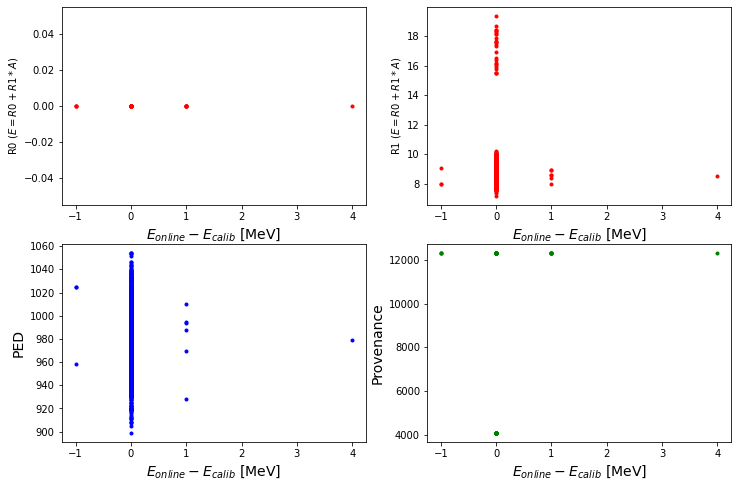

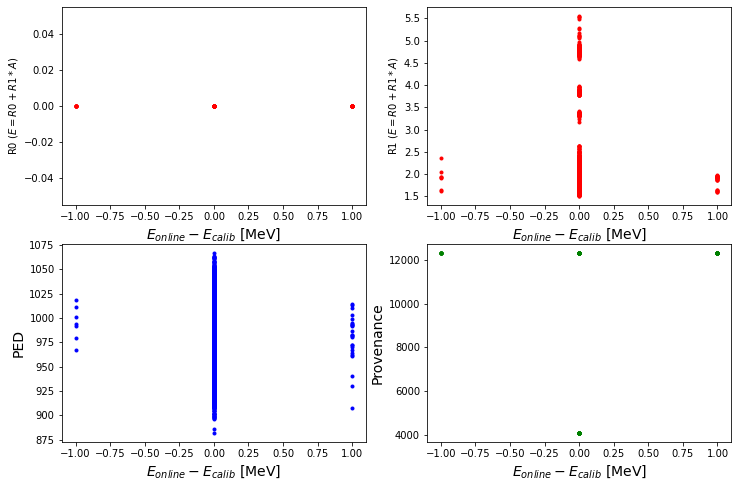

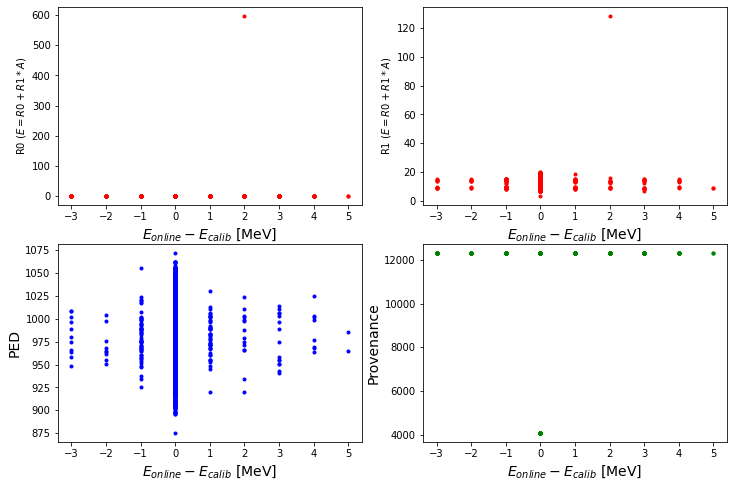

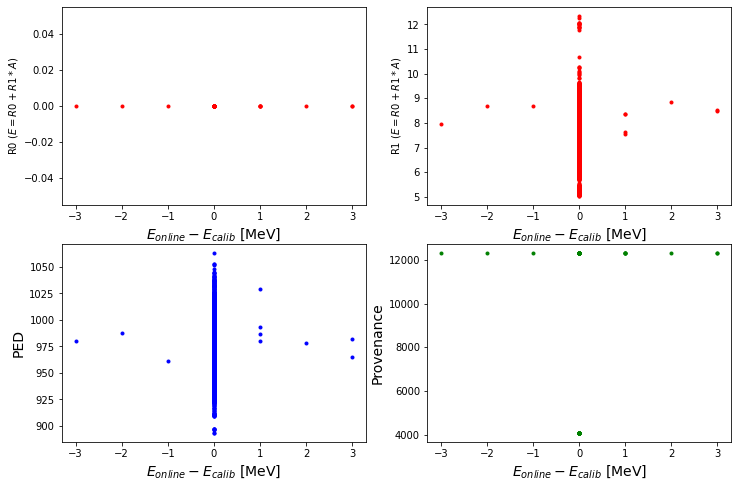

In [6]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

# resultFileAlias = '_OfflineCalib'# '_OFCDumper'
resultFileAliases = ['_OfflineCalib', '_OFCDumper', 'OFCdumper','onlineCalibDSP', '_ONLINECALIBTEST','_ONLINECALIBTESTNEW']
resultFileAliases = ['_ONLINECALIBTESTNEWPedScriptNew']
el_thrs          = [10,10,10,10,10] #GeV

calibType        = 'dumper'#['typical', 'database','dumper']
clusNames        = ['clusters']#, '711_roi']
# subClusNames     = ['Cluster', 'Window']
# xlabels          = ['Energy [MeV]', 'Energy [MeV]', 'Time [ns]','Time [ns]', 'Energy [MeV]','Time [ns]','Relative difference [%]']#,'Relative difference [%]']
# colors           = ['blue','red', 'black', 'green']
layers           = caloDict['Layer'][0:4]
xbins            = 60
# Vmin             = 1
# Vmax             = 20

plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

labelFontSize   = 14

for resultFileAlias, el_thr in zip(resultFileAliases, el_thrs):
    for clusName in clusNames:

        resultFiles = ['calibration/online_results_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, calibType, el_thr)]
        confFiles = ['calibration/online_conf_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, calibType, el_thr)]
                
        for resultFile, confFile in zip(resultFiles, confFiles):
            print(resultFile+'...')

            results     = np.load(resultFile, allow_pickle=True)
            confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()

            # el_thr = confDict['el_thr']
            nCellsChEta = confDict['nCellsChEta']
            nCellsChPhi = confDict['nCellsChPhi']
            nCellsRawChEta = confDict['nCellsRawChEta']
            nCellsRawChPhi = confDict['nCellsRawChPhi']

            for layer in layers:
                resultsInSampling   = results[layer].tolist()
                print(layer)

                ene_offline         = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat)
                ene_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat)
                ene_online          = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat)
                # ene_calibOffl       = list(np.concatenate(resultsInSampling['eneOfflineWindow']).flat)
                tau_offline         = list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat)
                tau_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
                tau_online          = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
                # tau_calibOffl       = list(np.concatenate(resultsInSampling['tauOfflineWindow']).flat)
                dspThr_calib        = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat)
                dspThr_online       = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat)
                dspThr_calibDiff    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat)

                Amp                 = list(np.concatenate(resultsInSampling['AWindow']).flat)
                gain                = list(np.concatenate(resultsInSampling['channelGainWindow']).flat)
                pedDB               = list(np.concatenate(resultsInSampling['channelPedWindow']).flat)
                pedDict             = list(np.concatenate(resultsInSampling['channelPedDictWindow']).flat)
                adc2Mev0            = list(np.concatenate(resultsInSampling['channelRamps0Window']).flat)
                adc2Mev1            = list(np.concatenate(resultsInSampling['channelRamps1Window']).flat)

                # eta_calib           = list(np.concatenate(resultsInSampling['channelEtaWindow']).flat)
                # phi_calib           = list(np.concatenate(resultsInSampling['channelPhiWindow']).flat)
                # eta_online          = list(np.concatenate(resultsInSampling['rawChEtaWindow']).flat)
                # phi_online          = list(np.concatenate(resultsInSampling['rawChPhiWindow']).flat)
                LArProv_online      = list(np.concatenate(resultsInSampling['rawChProvWindow']).flat)
                chid_calib          = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
                # chid_online     = list(np.concatenate(resultsInSampling[plot_keys_id[1]]).flat)

                diffEneOnCalibDSP   = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
                diffEneOffCalibDSP  = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
                diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
                # diffEneOffCalibOff  = [off - calibOff for (off, calibOff) in zip(ene_offline, ene_calibOffl)]
                diffTauOnCalibDSP   = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
                diffTauOffCalibDSP  = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
                diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]
                diffPedDbScript     = [db - scr for (db,scr) in zip(pedDB, pedDict)]

                zeroOnlineTau   = [idx for idx, element in enumerate(tau_online) if element == 0]# np.where(np.array(dspThr_calibDiff) <=0 )[0].tolist()
                noPassInThr     = [idx for idx, element in enumerate(dspThr_calibDiff) if element <= 0]

                # print(sum(np.array(pedDB) - np.array(pedDict)))
                for idx,cell in enumerate(diffEneOnCalibDSP):
                    if np.abs(diffEneOnCalibDSP[idx]) > 0:
                        print("Cell {}, gain {}, Eon/Ecalib {}/{}, error {}, A {}, pedDB/pedScript {}/{} ,pedDiff(db-scr) {}, R0 {}, R1 {}".format(chid_calib[idx], gain[idx], ene_online[idx], ene_calibDSP[idx], diffEneOnCalibDSP[idx], Amp[idx], pedDB[idx],pedDict[idx],diffPedDbScript[idx], adc2Mev0[idx], adc2Mev1[idx]))

                plt.figure(figsize=(12,8))
                plt.subplot(2,2,1)
                # plt.plot(range(0,len(pedDB)),pedDB,'ro')
                # plt.plot(range(0,len(pedDict)),pedDict,'bx')
                # plt.plot(pedDB,pedDict,'b.')
                plt.plot(diffEneOnCalibDSP,adc2Mev0,'r.')
                plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                plt.ylabel(r'R0 ($E = R0 + R1*A$)')
                plt.subplot(2,2,2)
                plt.plot(diffEneOnCalibDSP,adc2Mev1,'r.')
                plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                plt.ylabel(r'R1 ($E = R0 + R1*A$)')
                plt.subplot(2,2,3)
                plt.plot(diffEneOnCalibDSP,pedDict,'b.')
                plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                plt.ylabel(r'PED',fontsize=labelFontSize)
                plt.subplot(2,2,4)
                plt.plot(diffEneOnCalibDSP,LArProv_online,'g.')
                plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                plt.ylabel(r'Provenance',fontsize=labelFontSize)
                # plt.plot([min(pedDB), max(pedDB)],[min(pedDB), max(pedDB)],'r')
                plt.show()


                # Energy
                myFig = plt.figure(figsize=(15,4))
                plt.subplot(1,2,1)
                theBins     = xbins#np.histogram(ene_calibDSP,xbins)[1]
                # plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
                plt.hist(ene_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
                plt.hist(ene_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
                # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.title('Cell Calibrated Energy in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.yscale('log')
                plt.legend()

                plt.subplot(1,2,2)
                plt.hist(diffEneOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOnCalibDSP)), density=False)
                plt.title('Cell Calibrated Energy difference from RawChannel.')
                plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.legend()
                plt.yscale('log')

                filename = 'calibration/calibPlots/analysis1_calibOnline/{}_eleThr{}_ene_{}_{}_{}.pdf'.format(resultFileAlias, el_thr, layer, clusName, 'window')
                plt.savefig(filename)
                plt.close(myFig)

                # Time
                myFig = plt.figure(figsize=(15,4))
                plt.subplot(1,2,1)
                theBins     = xbins#np.histogram(tau_calibDSP,xbins)[1]
                plt.hist([x*1000 for x in tau_offline],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
                plt.hist(tau_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
                plt.hist(tau_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
                # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.title('Cell DSP Calibrated Time in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.xlabel('Time [ps]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.yscale('log')
                plt.legend()

                plt.subplot(1,2,2)
                plt.hist(diffTauOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffTauOnCalibDSP)), density=False)
                plt.title('Cell DSP Calibrated Time difference from RawChannel.')
                plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.legend()
                plt.yscale('log')
                filename = 'calibration/calibPlots/analysis1_calibOnline/{}_eleThr{}_time_{}_{}_{}.pdf'.format(resultFileAlias, el_thr, layer, clusName, 'window')
                plt.savefig(filename)
                plt.close(myFig)

### B.1) General plots

In [6]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

resultFileAlias = '_OfflineCalib'# '_OFCDumper'
el_thr          = 10 #GeV

calibType        = 'dumper'#['typical', 'database','dumper']
clusNames        = ['clusters']#, '711_roi']
# subClusNames     = ['Cluster', 'Window']
# xlabels          = ['Energy [MeV]', 'Energy [MeV]', 'Time [ns]','Time [ns]', 'Energy [MeV]','Time [ns]','Relative difference [%]']#,'Relative difference [%]']
# colors           = ['blue','red', 'black', 'green']
layers           = caloDict['Layer'][0:4]
xbins            = 50
# Vmin             = 1
# Vmax             = 20

plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
# plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

labelFontSize   = 14

for clusName in clusNames:

    resultFiles = ['calibration/online_results_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, calibType, el_thr)]
    confFiles = ['calibration/online_conf_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, calibType, el_thr)]
            
    for resultFile, confFile in zip(resultFiles, confFiles):
        print(resultFile+'...')

        results     = np.load(resultFile, allow_pickle=True)
        confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()

        # el_thr = confDict['el_thr']
        nCellsChEta = confDict['nCellsChEta']
        nCellsChPhi = confDict['nCellsChPhi']
        nCellsRawChEta = confDict['nCellsRawChEta']
        nCellsRawChPhi = confDict['nCellsRawChPhi']

        for layer in layers:
            resultsInSampling   = results[layer].tolist()
            print(layer)

            ene_offline         = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat)
            ene_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat)
            ene_online          = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat)
            ene_calibOffl       = list(np.concatenate(resultsInSampling['eneOfflineWindow']).flat)
            tau_offline         = list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat)
            tau_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
            tau_online          = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
            tau_calibOffl       = list(np.concatenate(resultsInSampling['tauOfflineWindow']).flat)
            dspThr_calib        = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat)
            dspThr_online       = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat)
            dspThr_calibDiff    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat)
            
            eta_calib           = list(np.concatenate(resultsInSampling['channelEtaWindow']).flat)
            phi_calib           = list(np.concatenate(resultsInSampling['channelPhiWindow']).flat)
            eta_online          = list(np.concatenate(resultsInSampling['rawChEtaWindow']).flat)
            phi_online          = list(np.concatenate(resultsInSampling['rawChPhiWindow']).flat)
            LArProv_online      = list(np.concatenate(resultsInSampling['rawChProvWindow']).flat)

            diffEneOnCalibDSP   = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
            diffEneOffCalibDSP  = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
            diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
            diffEneOffCalibOff  = [off - calibOff for (off, calibOff) in zip(ene_offline, ene_calibOffl)]
            diffTauOnCalibDSP   = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
            diffTauOffCalibDSP  = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
            diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]

            zeroOnlineTau   = [idx for idx, element in enumerate(tau_online) if element == 0]# np.where(np.array(dspThr_calibDiff) <=0 )[0].tolist()
            noPassInThr     = [idx for idx, element in enumerate(dspThr_calibDiff) if element <= 0]

            # chid_calib      = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
            # chid_online     = list(np.concatenate(resultsInSampling[plot_keys_id[1]]).flat)

            # Energy
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            theBins     = np.histogram(ene_online,xbins)[1]
            # plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(ene_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(ene_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell Calibrated Energy in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(2,2,2)
            plt.hist(diffEneOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOnCalibDSP)), density=False)
            plt.title('Cell Calibrated Energy difference from RawChannel.')
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')

            plt.subplot(2,2,3)
            theBins     = np.histogram(ene_offline,xbins)[1]
            plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            # plt.hist(ene_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            # plt.hist(ene_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            plt.hist(ene_calibOffl,bins=theBins,histtype='step', color='blue',label='Offline (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell Calibrated Energy in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(2,2,4)
            plt.hist(diffEneOffCalibOff,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOnCalibDSP)), density=False)
            plt.title('Cell Calibrated Energy difference from CaloCell.')
            plt.xlabel(r'$E_{offline} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')

            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_ene_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.close(myFig)

            # Time
            myFig = plt.figure(figsize=(15,4))
            plt.subplot(1,2,1)
            theBins     = np.histogram(tau_online,xbins)[1]
            plt.hist([x*1000 for x in tau_offline],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(tau_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(tau_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell DSP Calibrated Time in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel('Time [ps]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.yscale('log')
            plt.legend()

            plt.subplot(1,2,2)
            plt.hist(diffTauOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffTauOnCalibDSP)), density=False)
            plt.title('Cell DSP Calibrated Time difference from RawChannel.')
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            plt.legend()
            plt.yscale('log')
            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_time_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.close(myFig)

            # Eta/Phi vs energy vs error
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            theBins     = np.histogram(eta_calib,30)[1]
            # plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(eta_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(eta_calib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell '+r'$\eta$'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\eta$',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            # plt.yscale('log')
            plt.legend()

            plt.subplot(2,2,2)
            plt.scatter(eta_calib,eta_online, marker='.',label='Cell '+r'$\eta$',color='blue')
            plt.title('Cell Calibrated Energy difference from RawChannel.')
            plt.xlabel(r'cell calib. $\eta$',fontsize=labelFontSize)
            plt.ylabel(r'cell DSP. $\eta$',fontsize=labelFontSize)
            plt.legend()
            # plt.yscale('log')

            plt.subplot(2,2,3)
            theBins     = np.histogram(phi_calib,63)[1]
            # plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
            plt.hist(phi_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
            plt.hist(phi_calib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
            # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.title('Cell '+r'$\phi$'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\phi$',fontsize=labelFontSize)
            plt.ylabel("counts",fontsize=labelFontSize)
            # plt.yscale('log')
            plt.legend()

            plt.subplot(2,2,4)
            plt.scatter(phi_calib,phi_online, marker='.',label='Cell '+r'$\eta$',color='blue')
            plt.title('Cell Calibrated Energy difference from RawChannel.')
            plt.xlabel(r'cell calib. $\phi$',fontsize=labelFontSize)
            plt.ylabel(r'cell DSP. $\phi$',fontsize=labelFontSize)
            plt.legend()
            # plt.yscale('log')

            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_etaPhi_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.close(myFig)

            ## Scatter Plot
            myFig = plt.figure(figsize=(15,4))
            # ax = myFig.add_subplot(1, 2, 1, projection='scatter_density')
            # print('plot 1')
            # density = ax.scatter_density(ene_calibDSP, ene_online,vmin=min(ene_calibDSP),vmax=Vmax,cmap=white_viridis)
            # myFig.colorbar(density).set_label('Points/pixel', size=10)
            plt.subplot(1,2,1)
            plt.scatter(ene_calibDSP,ene_online, marker='.',label='DSP Calibrated Energy',color='blue')
            plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell DSP Calibrated Energy from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            # plt.xlabel('Calibration from Dumper')
            plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            # plt.ylabel("RawChannel container")
            plt.ylabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
            plt.legend()

            # ax = myFig.add_subplot(1, 2, 2, projection='scatter_density')
            # print('plot 2')
            # density = ax.scatter_density(tau_calibDSP, tau_online,vmin=min(tau_calibDSP),vmax=Vmax,cmap=white_viridis)
            # myFig.colorbar(density).set_label('Points/pixel', size=10)
            plt.subplot(1,2,2)
            plt.scatter(tau_calibDSP,tau_online, marker='.',label='DSP Calibrated Time',color='black')
            plt.plot([min(tau_calibDSP), max(tau_calibDSP)],[min(tau_calibDSP), max(tau_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell DSP Calibrated from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            # plt.xlabel('Calibration from Dumper')
            plt.xlabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            # plt.ylabel("RawChannel container")
            plt.ylabel(r'$\tau_{online}$ [ps]',fontsize=labelFontSize)
            plt.legend()
            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_scatter_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.close(myFig)

            ## Scatter Diff
            myFig = plt.figure(figsize=(15,12))
            # ax = myFig.add_subplot(2, 2, 1, projection='scatter_density')
            # print('plot 3')
            # density = ax.scatter_density(diffEneOnCalibDSP, ene_online,vmin=min(diffEneOnCalibDSP),vmax=Vmax,cmap=white_viridis)
            # myFig.colorbar(density).set_label('Points/pixel', size=10)
            plt.subplot(2,2,1)
            plt.scatter(diffEneOnCalibDSP,ene_online, marker='.',label='DSP Calibrated Energy Difference',color='blue')
            # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal')
            plt.title('Cell DSP Calibrated Energy from Online in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
            # plt.legend()

            # ax = myFig.add_subplot(2, 2, 2, projection='scatter_density')
            # density = ax.scatter_density(diffTauOnCalibDSP, tau_online,vmin=min(diffTauOnCalibDSP),vmax=Vmax,cmap=white_viridis)
            plt.subplot(2,2,2)
            plt.scatter(diffTauOnCalibDSP,tau_online, marker='.',label='DSP Calibrated Time Difference',color='black')
            # plt.plot([min(tau_calibDSP), max(tau_calibDSP)],[min(tau_calibDSP), max(tau_calibDSP)], '--r',label='Diagonal')
            plt.title('Cell DSP Calibrated Time from Online.',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online}$')
            # plt.legend()

            # ax = myFig.add_subplot(2, 2, 3, projection='scatter_density')
            # density = ax.scatter_density(diffEneOffCalibDSP, ene_offline,vmin=min(diffEneOffCalibDSP),vmax=Vmax,cmap=white_viridis)
            plt.subplot(2,2,3)
            plt.scatter(diffEneOffCalibDSP,ene_offline, marker='.',label='DSP Calibrated Energy Difference',color='blue')
            # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal')
            plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{offline} - E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$E_{offline}$',fontsize=labelFontSize)
            # plt.legend()

            # ax = myFig.add_subplot(2, 2, 4, projection='scatter_density')
            # density = ax.scatter_density(diffEneOffOnline, ene_offline,vmin=min(diffEneOffOnline),vmax=Vmax,cmap=white_viridis)
            plt.subplot(2,2,4)
            plt.scatter(diffEneOffOnline,ene_offline, marker='.',label='DSP Calibrated Energy Difference',color='blue')
            # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal')
            plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{offline} - E_{online}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$E_{offline}$',fontsize=labelFontSize)
            plt.legend()
            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_scatterDiff_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.close(myFig)

            ## DSP Threshold vs Timing
            myFig = plt.figure(figsize=(15,12))
            # ax = myFig.add_subplot(2, 2, 1, projection='scatter_density')
            # density = ax.scatter_density(dspThr_online, dspThr_calib,vmin=min(dspThr_online),vmax=Vmax,cmap=white_viridis)
            plt.subplot(2,2,1)
            plt.scatter(dspThr_online, dspThr_calib, marker='.',label='DSP Thresholds',color='blue')
            plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal',linewidth=0.2)
            plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{thr}$ online [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$E_{thr}$ calib [MeV]',fontsize=labelFontSize)
            plt.legend()

            # ax = myFig.add_subplot(2, 2, 2, projection='scatter_density')
            # density = ax.scatter_density(dspThr_calib, diffTauOnCalibDSP,vmin=min(dspThr_calib),vmax=Vmax,cmap=white_viridis)
            plt.subplot(2,2,2)
            plt.scatter(dspThr_calib, diffTauOnCalibDSP, marker='.',label='DSP Thresholds',color='blue')
            # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal')
            plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{thr}$ calib [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            # plt.legend()

            # ax = myFig.add_subplot(2, 2, 3, projection='scatter_density')
            # density = ax.scatter_density(ene_calibDSP, diffTauOnCalibDSP,vmin=min(ene_calibDSP),vmax=Vmax,cmap=white_viridis)
            plt.subplot(2,2,3)
            plt.scatter(ene_calibDSP, diffTauOnCalibDSP, marker='.',label='DSP Thresholds',color='blue')
            # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal')
            plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            # plt.legend()

            plt.subplot(2,2,4)
            plt.scatter(np.array(LArProv_online)[noPassInThr],np.array(dspThr_calib)[noPassInThr], marker='.',label='Provenance and DSP Thresholds', color='blue')
            plt.title('Cell provenance and its Calibration DSP_thr difference')
            plt.xlabel('Provenance [no unit]',fontsize=labelFontSize)
            plt.ylabel(r'$E_{thr}$ calib [MeV]',fontsize=labelFontSize)

            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_scatterThreshold_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.close(myFig)

            ## DSP Threshold Difference on LarRawChannelBuilder
            # errorTimingEstimation = [idx for idx, element in enumerate(diffTauOnCalibDSP) if element != 0] # get times different from zero

            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            # - show the difference in dsp_th for values where tau_onl==0, by its error from calib vs online tau.
            plt.scatter(np.array(diffTauOnCalibDSP)[zeroOnlineTau],np.array(dspThr_calibDiff)[zeroOnlineTau], marker='.',label='DSP Thresholds',color='blue')
            plt.title(r'$\tau_{online}=0$'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,2)
            # - show the tau_online for the calib_thr that doesn't passed through eCut (dspThr).
            # - expected: every tau_online should be zero!
            plt.scatter(np.array(tau_online)[noPassInThr],np.array(dspThr_calibDiff)[noPassInThr], marker='.',label='DSP Thresholds',color='blue')
            plt.title('Cells not passed in DSP threshold (calib), {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online}$ [ps]',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            # - show the ene_online for the calib_thr that doesn't passed through eCut (dspThr).
            # - expected: 
            plt.scatter(np.array(diffTauOnCalibDSP)[noPassInThr],np.array(dspThr_calibDiff)[noPassInThr], marker='.',label='DSP Thresholds',color='blue')
            plt.title('Cells not passed in DSP threshold (calib), {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
            # plt.xlabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
            plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)

            plt.subplot(2,2,4)
            # - show the ene_calibDSP for the calib_thr that doesn't passed through eCut (dspThr).
            # - expected: 
            plt.scatter(np.array(ene_calibDSP)[noPassInThr],np.array(dspThr_calibDiff)[noPassInThr], marker='.',label='DSP Thresholds',color='blue')
            plt.title('Cells not passed in DSP threshold (calib), {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)

            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_scatterThrDifference_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.show()
            plt.close(myFig)

            ## Precision
            zeroTo8GeV = [idx for idx, element in enumerate(ene_online) if element <= 8192]
            eightTo65GeV = [idx for idx, element in enumerate(ene_online) if ((element > 8192) and (element <= 65536))]
            sixtyFiveTo524GeV = [idx for idx, element in enumerate(ene_online) if ((element > 65536) and (element <= 524288))]
            higherEnergies = [idx for idx, element in enumerate(ene_online) if (element > 524288)]
            
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            # - 
            plt.scatter(np.array(diffTauOnCalibDSP)[zeroTo8GeV],np.array(ene_calibDSP)[zeroTo8GeV], marker='.',label='DSP Energy',color='blue')
            plt.title(r'$E_{calib} < 8192 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}-E_{calib}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,2)
            # - 
            # - expected: 
            plt.scatter(np.array(diffTauOnCalibDSP)[eightTo65GeV],np.array(ene_calibDSP)[eightTo65GeV], marker='.',label='DSP Energy',color='blue')
            plt.title(r'$E_{calib} < 65536 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}-E_{calib}$ [MeV]',fontsize=labelFontSize)

            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_energyUncertainties_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.show()
            plt.close(myFig)

            ## Provenance
            # myFig = plt.figure(figsize=(15,6))
            # plt.subplot(1,2,1)
            # plt.scatter()


calibration/online_results_analysis_OfflineCalib_clusters_dumper_etCut20.npz...
PreSamplerB
EMB1
EMB2
EMB3


In [11]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

resultFileAlias = '_OFCDumper'
el_thr          = 0 #GeV

calibType       = 'dumper'#['typical', 'database','dumper']
clusNames        = ['clusters']#, '711_roi']
# subClusNames     = ['Cluster', 'Window']
# xlabels          = ['Energy [MeV]', 'Energy [MeV]', 'Time [ns]','Time [ns]', 'Energy [MeV]','Time [ns]','Relative difference [%]']#,'Relative difference [%]']
# colors           = ['blue','red', 'black', 'green']
layers           = caloDict['Layer'][0:4]
xbins            = 50
# Vmin             = 1
# Vmax             = 20
plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
# plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

labelFontSize   = 14

for clusName in clusNames:

    resultFiles = ['calibration/online_results_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, calibType, el_thr)]
    confFiles = ['calibration/online_conf_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, calibType, el_thr)]
            
    for resultFile, confFile in zip(resultFiles, confFiles):
        print(resultFile+'...')

        results     = np.load(resultFile, allow_pickle=True)
        confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()

        # el_thr = confDict['el_thr']
        nCellsChEta = confDict['nCellsChEta']
        nCellsChPhi = confDict['nCellsChPhi']
        nCellsRawChEta = confDict['nCellsRawChEta']
        nCellsRawChPhi = confDict['nCellsRawChPhi']

        for layer in layers:
            resultsInSampling   = results[layer].tolist()
            print(layer)

            ene_offline     = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat)
            ene_calibDSP       = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat)
            ene_online      = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat)
            tau_offline     = list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat)
            tau_calibDSP       = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
            tau_online      = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
            dspThr_calib    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat)
            dspThr_online   = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat)
            dspThr_calibDiff= list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat)

            eta_calib       = list(np.concatenate(resultsInSampling['channelEtaWindow']).flat)
            phi_calib       = list(np.concatenate(resultsInSampling['channelPhiWindow']).flat)
            eta_online      = list(np.concatenate(resultsInSampling['rawChEtaWindow']).flat)
            phi_online      = list(np.concatenate(resultsInSampling['rawChPhiWindow']).flat)

            diffEneOnCalibDSP      = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
            diffEneOffCalibDSP     = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
            diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
            diffTauOnCalibDSP      = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
            diffTauOffCalibDSP     = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
            diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]
            
            # chid_calib      = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
            # chid_online     = list(np.concatenate(resultsInSampling[plot_keys_id[1]]).flat)

            ## Precision
            zeroTo8GeV = [idx for idx, element in enumerate(ene_online) if element <= 8192]
            eightTo65GeV = [idx for idx, element in enumerate(ene_online) if ((element > 8192) and (element <= 65536))]
            sixtyFiveTo524GeV = [idx for idx, element in enumerate(ene_online) if ((element > 65536) and (element <= 524288))]
            higherEnergies = [idx for idx, element in enumerate(ene_online) if (element > 524288)]
            
            diffEneOnCalibDSP
            myFig = plt.figure(figsize=(15,12))
            plt.subplot(2,2,1)
            # - 
            plt.scatter(np.array(diffEneOnCalibDSP)[zeroTo8GeV],np.array(ene_calibDSP)[zeroTo8GeV], marker='.',label='DSP Energy',color='blue')
            plt.title(r'$E_{calib} < 8192 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}-E_{calib}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,2)
            # - 
            # - expected: 
            plt.scatter(np.array(diffEneOnCalibDSP)[eightTo65GeV],np.array(ene_calibDSP)[eightTo65GeV], marker='.',label='DSP Energy',color='blue')
            plt.title(r'$8.192 < E_{calib} < 65.536 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}-E_{calib}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            # - 
            # - expected: 
            plt.scatter(np.array(diffEneOnCalibDSP)[sixtyFiveTo524GeV],np.array(ene_calibDSP)[sixtyFiveTo524GeV], marker='.',label='DSP Energy',color='blue')
            plt.title(r'$65.536 < E_{calib} < 524.288 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}-E_{calib}$ [MeV]',fontsize=labelFontSize)

            plt.subplot(2,2,3)
            # - 
            # - expected: 
            plt.scatter(np.array(diffEneOnCalibDSP)[higherEnergies],np.array(ene_calibDSP)[higherEnergies], marker='.',label='DSP Energy',color='blue')
            plt.title(r'$E_{calib} > 524.288 $ MeV'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            plt.ylabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
            plt.xlabel(r'$E_{online}-E_{calib}$ [MeV]',fontsize=labelFontSize)

            filename = 'calibration/calibPlots/analysis1_calibOnline/eleThr{}_energyUncertainties_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
            plt.savefig(filename)
            plt.show()
            plt.close(myFig)

calibration/online_results_analysis_OFCDumper_clusters_dumper_etCut0.npz...
PreSamplerB


/eos/home-m/mhufnage/analysisEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


EMB1


/eos/home-m/mhufnage/analysisEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


EMB2


/eos/home-m/mhufnage/analysisEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


EMB3


/eos/home-m/mhufnage/analysisEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


### B.2) Quantization

In [14]:
resultFilesAliases = ['OFCdumper','_alfa32_Etau32','_alfaNQuant_Etau32','_alfa32_EtauNQuant','_alfaNQuant_EtauNQuant','_alfaFxp_EtauFxp']
resultFilesAliases = ['_alfa32_Etau32']

matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

calibType       = 'dumper'#['typical', 'database','dumper']
clusNames        = ['clusters']#, '711_roi']
# subClusNames     = ['Cluster', 'Window']
el_thr          = 0 #GeV

layers           = caloDict['Layer'][0:4]
xbins            = 50
# Vmin             = 1
# Vmax             = 20
plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
# plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

labelFontSize   = 14

for resultFileAlias in resultFilesAliases:
    for clusName in clusNames:

        resultFiles = ['calibration/online_results_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, calibType, el_thr)]
        confFiles = ['calibration/online_conf_analysis{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, calibType, el_thr)]

        for resultFile, confFile in zip(resultFiles, confFiles):
            print(resultFile+'...')

            results     = np.load(resultFile, allow_pickle=True)
            confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()

            # el_thr = confDict['el_thr']
            nCellsChEta = confDict['nCellsChEta']
            nCellsChPhi = confDict['nCellsChPhi']
            nCellsRawChEta = confDict['nCellsRawChEta']
            nCellsRawChPhi = confDict['nCellsRawChPhi']

            for layer in layers:
                resultsInSampling   = results[layer].tolist()

                ene_offline     = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat)
                ene_calibDSP       = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat)
                ene_online      = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat)
                tau_offline     = list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat)
                tau_calibDSP       = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
                tau_online      = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat)#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
                dspThr_calib    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat)
                dspThr_online   = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat)
                dspThr_calibDiff= list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat)

                diffEneOnCalibDSP      = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
                diffEneOffCalibDSP     = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
                diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
                diffTauOnCalibDSP      = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
                diffTauOffCalibDSP     = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
                diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]
                
                # chid_calib      = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
                # chid_online     = list(np.concatenate(resultsInSampling[plot_keys_id[1]]).flat)

                # Energy
                myFig = plt.figure(figsize=(15,4))
                plt.subplot(1,2,1)
                theBins     = np.histogram(ene_offline,xbins)[1]
                plt.hist(ene_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
                plt.hist(ene_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
                plt.hist(ene_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
                # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.title('Cell Calibrated Energy in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.yscale('log')
                plt.legend()

                plt.subplot(1,2,2)
                plt.hist(diffEneOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOnCalibDSP)), density=False)
                plt.title('Cell Calibrated Energy difference from RawChannel.')
                plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.legend()
                plt.yscale('log')
                filename = 'calibration/calibPlots/analysis2_DSPquant/ene_{}_{}_{}_{}.pdf'.format(resultFileAlias, layer, clusName, 'window')
                plt.savefig(filename)
                plt.close(myFig)

                # Time
                myFig = plt.figure(figsize=(15,4))
                plt.subplot(1,2,1)
                theBins     = np.histogram(tau_online,xbins)[1]
                plt.hist([x*1000 for x in tau_offline],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
                plt.hist(tau_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
                plt.hist(tau_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
                # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.title('Cell DSP Calibrated Time in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.xlabel('Time [ps]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.yscale('log')
                plt.legend()

                plt.subplot(1,2,2)
                plt.hist(diffTauOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='Difference between calib and online.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffTauOnCalibDSP)), density=False)
                plt.title('Cell DSP Calibrated Time difference from RawChannel.')
                plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.legend()
                plt.yscale('log')
                filename = 'calibration/calibPlots/analysis2_DSPquant/time_{}_{}_{}_{}.pdf'.format(resultFileAlias, layer, clusName, 'window')
                plt.savefig(filename)
                plt.close(myFig)

                ## Scatter Plot
                # myFig = plt.figure(figsize=(15,4))
                # plt.subplot(1,2,1)
                # plt.scatter(ene_calibDSP,ene_online, marker='.',label='DSP Calibrated Energy',color='blue')
                # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
                # plt.title('Cell DSP Calibrated Energy from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # # plt.xlabel('Calibration from Dumper')
                # plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
                # # plt.ylabel("RawChannel container")
                # plt.ylabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
                # plt.legend()

                # plt.subplot(1,2,2)
                # plt.scatter(tau_calibDSP,tau_online, marker='.',label='DSP Calibrated Time',color='black')
                # plt.plot([min(tau_calibDSP), max(tau_calibDSP)],[min(tau_calibDSP), max(tau_calibDSP)], '--r',label='Diagonal',linewidth=0.2)
                # plt.title('Cell DSP Calibrated from RawChannel in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # # plt.xlabel('Calibration from Dumper')
                # plt.xlabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)
                # # plt.ylabel("RawChannel container")
                # plt.ylabel(r'$\tau_{online}$ [ps]',fontsize=labelFontSize)
                # plt.legend()
                # filename = 'calibration/analysis2_DSPquant/scatter_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
                # plt.savefig(filename)
                # plt.close(myFig)

                # ## Scatter Diff
                # myFig = plt.figure(figsize=(15,12))
                # plt.subplot(2,2,1)
                # plt.scatter(diffEneOnCalibDSP,ene_online, marker='.',label='DSP Calibrated Energy Difference',color='blue')
                # # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal')
                # plt.title('Cell DSP Calibrated Energy from Online in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                # plt.ylabel(r'$E_{online}$ [MeV]',fontsize=labelFontSize)
                # # plt.legend()

                # plt.subplot(2,2,2)
                # plt.scatter(diffTauOnCalibDSP,tau_online, marker='.',label='DSP Calibrated Time Difference',color='black')
                # # plt.plot([min(tau_calibDSP), max(tau_calibDSP)],[min(tau_calibDSP), max(tau_calibDSP)], '--r',label='Diagonal')
                # plt.title('Cell DSP Calibrated Time from Online.',fontsize=labelFontSize)
                # plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
                # plt.ylabel(r'$\tau_{online}$')
                # # plt.legend()

                # plt.subplot(2,2,3)
                # plt.scatter(diffEneOffCalibDSP,ene_offline, marker='.',label='DSP Calibrated Energy Difference',color='blue')
                # # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal')
                # plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.xlabel(r'$E_{offline} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                # plt.ylabel(r'$E_{offline}$',fontsize=labelFontSize)
                # # plt.legend()

                # plt.subplot(2,2,4)
                # plt.scatter(diffEneOffOnline,ene_offline, marker='.',label='DSP Calibrated Energy Difference',color='blue')
                # # plt.plot([min(ene_calibDSP), max(ene_calibDSP)],[min(ene_calibDSP), max(ene_calibDSP)], '--r',label='Diagonal')
                # plt.title('Cell DSP Calibrated Energy from Offline in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.xlabel(r'$E_{offline} - E_{online}$ [MeV]',fontsize=labelFontSize)
                # plt.ylabel(r'$E_{offline}$',fontsize=labelFontSize)
                # plt.legend()
                # filename = 'calibration/analysis2_DSPquant/scatterDiff_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
                # plt.savefig(filename)
                # plt.close(myFig)

                # ## DSP Threshold vs Timing
                # myFig = plt.figure(figsize=(15,12))
                # plt.subplot(2,2,1)
                # plt.scatter(dspThr_online, dspThr_calib, marker='.',label='DSP Thresholds',color='blue')
                # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal',linewidth=0.2)
                # plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.xlabel(r'$E_{thr}$ online [MeV]',fontsize=labelFontSize)
                # plt.ylabel(r'$E_{thr}$ calib [MeV]',fontsize=labelFontSize)
                # plt.legend()

                # plt.subplot(2,2,2)
                # plt.scatter(dspThr_calib, diffTauOnCalibDSP, marker='.',label='DSP Thresholds',color='blue')
                # # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal')
                # plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.xlabel(r'$E_{thr}$ calib [MeV]',fontsize=labelFontSize)
                # plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
                # # plt.legend()

                # plt.subplot(2,2,3)
                # plt.scatter(ene_calibDSP, diffTauOnCalibDSP, marker='.',label='DSP Thresholds',color='blue')
                # # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal')
                # plt.title('Cell Run2 DSP thresholds in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)
                # plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
                # # plt.legend()
                # filename = 'calibration/analysis2_DSPquant/scatterThreshold_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
                # plt.savefig(filename)
                # plt.close(myFig)

                # ## DSP Threshold Difference on LarRawChannelBuilder
                # zeroOnlineTau   = [idx for idx, element in enumerate(tau_online) if element == 0]# np.where(np.array(dspThr_calibDiff) <=0 )[0].tolist()
                # noPassInThr     = [idx for idx, element in enumerate(dspThr_calibDiff) if element <= 0]
                # # errorTimingEstimation = [idx for idx, element in enumerate(diffTauOnCalibDSP) if element != 0] # get times different from zero

                # myFig = plt.figure(figsize=(15,12))
                # plt.subplot(2,2,1)
                # # - show the difference in dsp_th for values where tau_onl==0, by its error from calib vs online tau.
                # plt.scatter(np.array(diffTauOnCalibDSP)[zeroOnlineTau],np.array(dspThr_calibDiff)[zeroOnlineTau], marker='.',label='DSP Thresholds',color='blue')
                # plt.title(r'$\tau_{online}=0$'+' in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
                # plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)

                # plt.subplot(2,2,2)
                # # - show the tau_online for the calib_thr that doesn't passed through eCut (dspThr).
                # # - expected: every tau_online should be zero!
                # plt.scatter(np.array(tau_online)[noPassInThr],np.array(dspThr_calibDiff)[noPassInThr], marker='.',label='DSP Thresholds',color='blue')
                # plt.title('Cells not passed in DSP threshold (calib), {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
                # plt.xlabel(r'$\tau_{online}$ [ps]',fontsize=labelFontSize)

                # plt.subplot(2,2,3)
                # # - show the ene_online for the calib_thr that doesn't passed through eCut (dspThr).
                # # - expected: 
                # plt.scatter(np.array(tau_calibDSP)[noPassInThr],np.array(dspThr_calibDiff)[noPassInThr], marker='.',label='DSP Thresholds',color='blue')
                # plt.title('Cells not passed in DSP threshold (calib), {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
                # plt.xlabel(r'$\tau_{calib}$ [ps]',fontsize=labelFontSize)

                # plt.subplot(2,2,4)
                # # - show the ene_calibDSP for the calib_thr that doesn't passed through eCut (dspThr).
                # # - expected: 
                # plt.scatter(np.array(ene_calibDSP)[noPassInThr],np.array(dspThr_calibDiff)[noPassInThr], marker='.',label='DSP Thresholds',color='blue')
                # plt.title('Cells not passed in DSP threshold (calib), {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                # plt.ylabel(r'$E1 - DSP_{thr}$ [MeV]',fontsize=labelFontSize)
                # plt.xlabel(r'$E_{calib}$ [MeV]',fontsize=labelFontSize)

                # filename = 'calibration/analysis2_DSPquant/scatterThrDifference_{}_{}_{}.pdf'.format(el_thr, layer, clusName, 'window')
                # plt.savefig(filename)
                # plt.show()
                # plt.close(myFig)


calibration/online_results_analysis_alfa32_Etau32_clusters_dumper_etCut0.npz...


### B.3) Vertex-Timing

    I  - Observe energy and time for cells above e_cut = 500 MeV


In [4]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

# ----- Data Config -------
resultFileAliases   = ['timeResolutionAnalysis']
calibType           = 'dumper'#['typical', 'database','dumper']
clusNames           = ['clusters']#, '711_roi']
layers              = caloDict['Layer'][0:4]

# ----- Analysis Settings -------
xbins               = 60
cellEneCut          = 500 #MeV
labelFontSize       = 14

plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

leadingCellIndexes = []
leadingCellTimeOnline = []
leadingCellTimeCalib    = []
leadingCellTimeOffline = []
leadingCellEneOnline = []
leadingCellEneCalib = []
leadingCellEneOffline = []
leadingCellChannelId    = []
leadingCellChannelFT    = []
leadingCellElecVertex   = []

for resultFileAlias in resultFileAliases:
    for clusName in clusNames:

        resultFiles = ['calibration/vertex_results_analysis_{}_{}_{}.npz'.format(resultFileAlias, clusName, calibType)]
        confFiles = ['calibration/vertex_conf_analysis_{}_{}_{}.npz'.format(resultFileAlias, clusName, calibType)]
                
        for resultFile, confFile in zip(resultFiles, confFiles):
            print(resultFile+'...')

            results     = np.load(resultFile, allow_pickle=True)
            confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()
            
            nCellsChEta = confDict['nCellsChEta']
            nCellsChPhi = confDict['nCellsChPhi']
            nCellsRawChEta = confDict['nCellsRawChEta']
            nCellsRawChPhi = confDict['nCellsRawChPhi']

            for layer in layers:
                resultsInSampling   = results[layer].tolist()

                cellsAboveCut       = np.where(np.concatenate(resultsInSampling['rawChEnergyWindow']).flat >= cellEneCut)[0]

                ene_offline         = list(np.concatenate(resultsInSampling[plot_keys_ene[0]]).flat[cellsAboveCut])
                ene_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_ene[1]]).flat[cellsAboveCut])
                ene_online          = list(np.concatenate(resultsInSampling[plot_keys_ene[2]]).flat[cellsAboveCut])
                tau_offline         = [x*1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[0]]).flat[cellsAboveCut])]
                tau_calibDSP        = list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat[cellsAboveCut])#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[1]]).flat) ] # ps to ns
                tau_online          = list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat[cellsAboveCut])#[x/1000 for x in list(np.concatenate(resultsInSampling[plot_keys_time[2]]).flat) ] # ps to ns
                dspThr_calib        = list(np.concatenate(resultsInSampling[plot_keys_dspThr[0]]).flat[cellsAboveCut])
                dspThr_online       = list(np.concatenate(resultsInSampling[plot_keys_dspThr[1]]).flat[cellsAboveCut])
                dspThr_calibDiff    = list(np.concatenate(resultsInSampling[plot_keys_dspThr[2]]).flat[cellsAboveCut])
                chid_calib          = list(np.concatenate(resultsInSampling[plot_keys_id[0]]).flat)
                chid_online         = list(np.concatenate(resultsInSampling[plot_keys_id[1]]).flat)

                diffEneOnCalibDSP      = [onl - calib for (onl,calib) in zip(ene_online, ene_calibDSP)]
                diffEneOffCalibDSP     = [off - calib for (off,calib) in zip(ene_offline, ene_calibDSP)]
                diffEneOffOnline    = [off - onl for (off,onl) in zip(ene_offline, ene_online)]
                diffTauOnCalibDSP      = [onl - calib for (onl,calib) in zip(tau_online, tau_calibDSP)]
                diffTauOffCalibDSP     = [off - calib for (off,calib) in zip(tau_offline, tau_calibDSP)]
                diffTauOffOnline    = [off - onl for (off,onl) in zip(tau_offline, tau_online)]

            ## (I - Observe energy and time for cells above e_cut = 500 MeV)
                # Energy
                myFig = plt.figure(figsize=(15,4))
                plt.subplot(1,2,1)
                theBins     = np.histogram(ene_offline,xbins)[1]
                plt.hist(ene_offline,bins=xbins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
                plt.hist(ene_online,bins=xbins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
                plt.hist(ene_calibDSP,bins=xbins,histtype='step', color='red',label='Online (Dumper)', density=True)
                # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.title('Cell Calibrated Energy in {} at {}.'.format(clusName, layer)+r' cell $e_{cut} = $'+' {} MeV'.format(cellEneCut))
                plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.yscale('log')
                plt.legend()

                plt.subplot(1,2,2)
                plt.hist(diffEneOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='online - calib.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOnCalibDSP)), density=True)
                # plt.hist(diffEneOffCalibDSP,bins=20,histtype='stepfilled', color='yellow',alpha=0.2,label='offline - calib.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffEneOffCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffEneOffCalibDSP)), density=True)
                plt.title('Cell Calibrated Energy difference from RawChannel.')
                plt.xlabel(r'$E_{online} - E_{calib}$ [MeV]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.legend()
                plt.yscale('log')
                filename = 'calibration/calibPlots/analysis3_vertexTimeResolution/ene_{}_{}_{}_{}mevCellCut.pdf'.format(resultFileAlias, layer, clusName, cellEneCut)
                plt.savefig(filename)
                plt.close(myFig)

                # Time
                myFig = plt.figure(figsize=(15,4))
                plt.subplot(1,2,1)
                theBins     = np.histogram(tau_online,xbins)[1]
                plt.hist(tau_offline,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
                plt.hist(tau_online,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
                plt.hist(tau_calibDSP,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
                # plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                plt.title('Cell DSP Calibrated Time in {} at {}.'.format(clusName, layer)+r' cell $e_{cut} = $'+' {} MeV'.format(cellEneCut))
                plt.xlabel('Time [ps]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.yscale('log')
                plt.legend()

                plt.subplot(1,2,2)
                plt.hist(diffTauOnCalibDSP,bins=20,histtype='stepfilled', color='black',alpha=0.2,label='online - calib.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOnCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffTauOnCalibDSP)), density=True)
                # plt.hist(diffTauOffCalibDSP,bins=20,histtype='stepfilled', color='yellow',alpha=0.2,label='offline - calib.\n\t'+r'$\mu = ${:.2f}'.format(np.mean(diffTauOffCalibDSP))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(diffTauOffCalibDSP)), density=True)
                plt.title('Cell DSP Calibrated Time difference from RawChannel.')
                plt.xlabel(r'$\tau_{online} - \tau_{calib}$ [ps]',fontsize=labelFontSize)
                plt.ylabel("counts",fontsize=labelFontSize)
                plt.legend()
                plt.yscale('log')
                filename = 'calibration/calibPlots/analysis3_vertexTimeResolution/time_{}_{}_{}_{}mevCellCut.pdf'.format(resultFileAlias, layer, clusName, cellEneCut)
                plt.savefig(filename)
                plt.close(myFig)

# 


calibration/vertex_results_analysis_timeResolutionAnalysis_clusters_dumper.npz...


    II - Leading Cells time dispersion (All leading EMB2 Hottest cells)

calibration/vertex_results_analysis_timeResolutionAnalysis_clusters_dumper.npz...


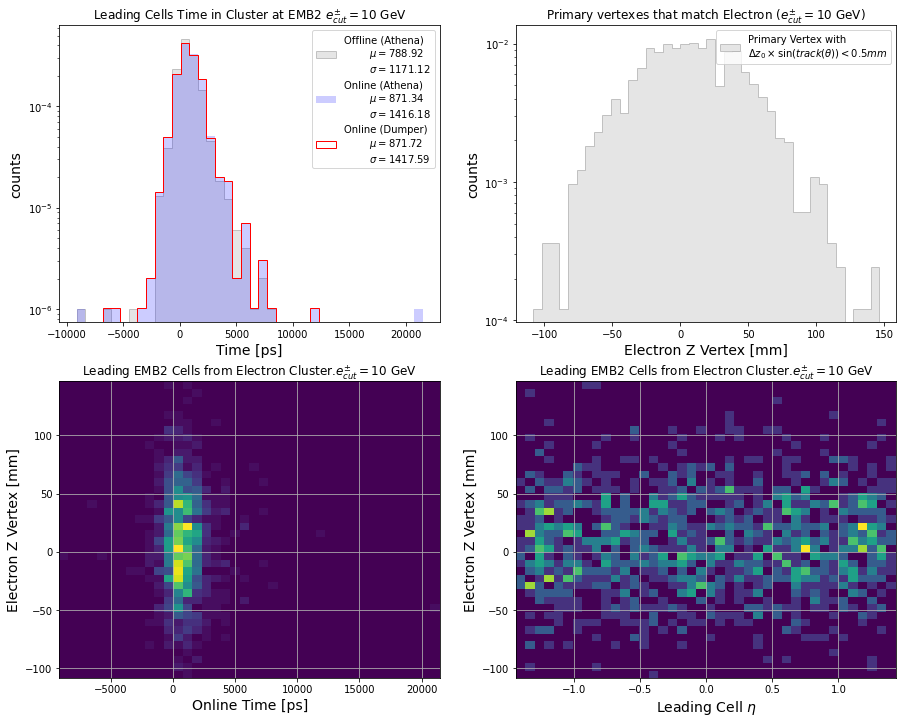

In [38]:
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

# ----- Data Config -------
resultFileAliases   = ['timeResolutionAnalysis']
calibType           = 'dumper'#['typical', 'database','dumper']
clusNames           = ['clusters']#, '711_roi']
layers              = caloDict['Layer'][0:4]

# ----- Analysis Settings -------
xbins               = 40
cellEneCut          = 500 #MeV
labelFontSize       = 14

plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

leadingCellIndexes = []
leadingCellTimeOnline = []
leadingCellTimeCalib    = []
leadingCellTimeOffline = []
leadingCellEneOnline = []
leadingCellEneCalib = []
leadingCellEneOffline = []
leadingCellChannelId    = []
leadingCellEta  = []
leadingCellPhi  = []
leadingCellChannelFT    = []
leadingCellElecVertex   = []

# -------------- Analysis  --------------
for resultFileAlias in resultFileAliases:
    for clusName in clusNames:

        resultFiles = ['calibration/vertex_results_analysis_{}_{}_{}.npz'.format(resultFileAlias, clusName, calibType)]
        confFiles = ['calibration/vertex_conf_analysis_{}_{}_{}.npz'.format(resultFileAlias, clusName, calibType)]
                
        for resultFile, confFile in zip(resultFiles, confFiles):
            print(resultFile+'...')

            results     = np.load(resultFile, allow_pickle=True)
            confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()
            el_thr      = confDict['el_thr']
            
            for layer in layers:
                resultsInSampling   = results[layer].tolist()

                if layer=='EMB2':
                    for idx, clusEne in enumerate(resultsInSampling['rawChEnergyWindow']):
                        if len(clusEne)==0:
                            continue
                        leadingCellIndexesByCluster = np.argmax(clusEne)

                        leadingCellIndexes.append(leadingCellIndexesByCluster)
                        leadingCellTimeOnline.append(resultsInSampling[plot_keys_time[2]][idx][leadingCellIndexesByCluster] )
                        leadingCellTimeCalib.append(resultsInSampling[plot_keys_time[1]][idx][leadingCellIndexesByCluster]   )
                        leadingCellTimeOffline.append(resultsInSampling[plot_keys_time[0]][idx][leadingCellIndexesByCluster])
                        leadingCellEneOnline.append(resultsInSampling[plot_keys_ene[2]][idx][leadingCellIndexesByCluster])
                        leadingCellEneCalib.append(resultsInSampling[plot_keys_ene[1]][idx][leadingCellIndexesByCluster])
                        leadingCellEneOffline.append(resultsInSampling[plot_keys_ene[0]][idx][leadingCellIndexesByCluster])
                        leadingCellChannelId.append(resultsInSampling[plot_keys_id[0]][idx][leadingCellIndexesByCluster])
                        leadingCellEta.append(resultsInSampling['channelEtaWindow'][idx][leadingCellIndexesByCluster])
                        leadingCellPhi.append(resultsInSampling['channelPhiWindow'][idx][leadingCellIndexesByCluster])

                        # elecIdx = resultsInSampling['datasetElectronIndex'][idx]
                        elecIdx = np.where(np.asarray(results['electron'].tolist()['datasetElectronIndex'],dtype=int) == int(resultsInSampling['datasetElectronIndex'][idx]))[0][0]
                        vertexZElectron = results['electron'].tolist()['electronVertexZ'][elecIdx]
                        # print('electron {}, electron {}, vertex {}'.format(resultsInSampling['datasetElectronIndex'][idx], elecIdx, vertexZElectron))
                        leadingCellElecVertex.append(vertexZElectron)
                        # leadingCell
                        # leadingCellChannelFT.append()

# --------------- Plots ---------------------
myFig = plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
theBins     = np.histogram(leadingCellTimeOnline,xbins)[1]
plt.hist([x*1000 for x in leadingCellTimeOffline],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+r'$\mu = ${:.2f}'.format(np.mean([x*1000 for x in leadingCellTimeOffline]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std([x*1000 for x in leadingCellTimeOffline])), density=True)
plt.hist(leadingCellTimeOnline,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(leadingCellTimeOnline))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(leadingCellTimeOnline)), density=True)
plt.hist(leadingCellTimeCalib,bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(leadingCellTimeCalib))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(leadingCellTimeCalib)), density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Leading Cells Time in Cluster at EMB2 '+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(2,2,2)
plt.hist(np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=xbins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Primary Vertex with \n'+r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', density=True)
# plt.text(0.4, 0.67, r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', transform=plt.gca().transAxes,fontsize=labelFontSize)
# plt.hist(leadingCellTimeOnline,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
# plt.hist(leadingCellTimeCalib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Primary vertexes that match Electron '+r'($e^{\pm}_{cut}=$'+'{} GeV)'.format(el_thr))
plt.xlabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(2,2,3)
plt.hist2d(np.asarray(leadingCellTimeOnline).reshape(len(leadingCellTimeOnline)), np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=[xbins,xbins])
plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Online Time [ps]',fontsize=labelFontSize)
plt.grid()

plt.subplot(2,2,4)
plt.hist2d(np.asarray(leadingCellEta).reshape(len(leadingCellEta)), np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=[xbins,xbins])
plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Leading Cell '+r'$\eta$',fontsize=labelFontSize)
plt.grid()
plt.show()

    III - Leading Cells time dispersion (Just an unique cell, that repeats most)

[3, 952541696]
[ 900  942 1020]


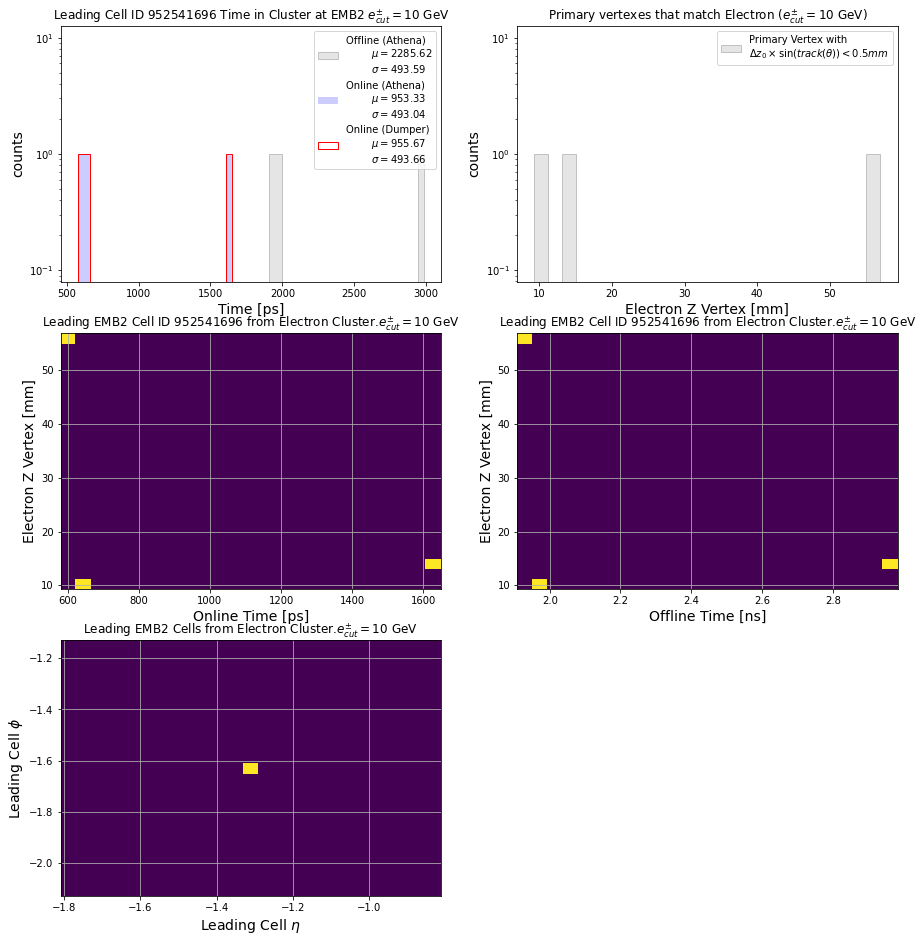

In [39]:
from collections import Counter

# ----- Analysis Settings -------
xbins               = 25
variableToSearch    = leadingCellChannelId#np.abs(leadingCellEta) # 


# ----- Find the most repeated Cell -------
nIdCellsDict = Counter(variableToSearch)

mostRepeatedCell = [0,9999999]

for id in nIdCellsDict.keys():
    if nIdCellsDict[id] > mostRepeatedCell[0]:
        mostRepeatedCell[0] = nIdCellsDict[id]
        mostRepeatedCell[1] = id

print(mostRepeatedCell)

leadingRepeatedCellsIdx = np.where(np.asarray(variableToSearch,dtype=object)==mostRepeatedCell[1])[0]
print(leadingRepeatedCellsIdx)

# --------------- Plots ---------------------
histDensity = False

myFig = plt.figure(figsize=(15,16))

plt.subplot(3,2,1)
theBins     = xbins#np.histogram(np.asarray(leadingCellTimeOnline)[leadingRepeatedCellsIdx],xbins)[1]
plt.hist(np.asarray([x*1000 for x in leadingCellTimeOffline])[leadingRepeatedCellsIdx],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(np.asarray([x*1000 for x in leadingCellTimeOffline])[leadingRepeatedCellsIdx]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(np.asarray([x*1000 for x in leadingCellTimeOffline])[leadingRepeatedCellsIdx])), density=histDensity)
plt.hist(np.asarray(leadingCellTimeOnline)[leadingRepeatedCellsIdx],bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(np.asarray(leadingCellTimeOnline)[leadingRepeatedCellsIdx]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(np.asarray(leadingCellTimeOnline)[leadingRepeatedCellsIdx])), density=histDensity)
plt.hist(np.asarray(leadingCellTimeCalib)[leadingRepeatedCellsIdx],bins=theBins,histtype='step', color='red',label='Online (Dumper)\n\t'+r'$\mu = ${:.2f}'.format(np.mean(np.asarray(leadingCellTimeCalib)[leadingRepeatedCellsIdx]))+'\n\t'+r'$\sigma = ${:.2f}'.format(np.std(np.asarray(leadingCellTimeCalib)[leadingRepeatedCellsIdx])), density=histDensity)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Leading Cell ID {} Time in Cluster at EMB2 '.format(mostRepeatedCell[1])+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(3,2,2)
plt.hist(np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex))[leadingRepeatedCellsIdx],bins=xbins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Primary Vertex with \n'+r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', density=histDensity)
# plt.text(0.4, 0.67, r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', transform=plt.gca().transAxes,fontsize=labelFontSize)
# plt.hist(leadingCellTimeOnline,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
# plt.hist(leadingCellTimeCalib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Primary vertexes that match Electron '+r'($e^{\pm}_{cut}=$'+'{} GeV)'.format(el_thr))
plt.xlabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(3,2,3)
plt.hist2d(np.asarray(leadingCellTimeOnline).reshape(len(leadingCellTimeOnline))[leadingRepeatedCellsIdx], np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex))[leadingRepeatedCellsIdx],bins=[xbins,xbins])
plt.title('Leading EMB2 Cell ID {} from Electron Cluster.'.format(mostRepeatedCell[1])+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Online Time [ps]',fontsize=labelFontSize)
plt.grid()

plt.subplot(3,2,4)
plt.hist2d(np.asarray(leadingCellTimeOffline).reshape(len(leadingCellTimeOffline))[leadingRepeatedCellsIdx], np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex))[leadingRepeatedCellsIdx],bins=[xbins,xbins])
plt.title('Leading EMB2 Cell ID {} from Electron Cluster.'.format(mostRepeatedCell[1])+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Offline Time [ns]',fontsize=labelFontSize)
plt.grid()

plt.subplot(3,2,5)
plt.hist2d(np.asarray(leadingCellEta).reshape(len(leadingCellEta))[leadingRepeatedCellsIdx], np.asarray(leadingCellPhi).reshape(len(leadingCellPhi))[leadingRepeatedCellsIdx],bins=[xbins,xbins])
plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Leading Cell '+r'$\phi$',fontsize=labelFontSize)
plt.xlabel('Leading Cell '+r'$\eta$',fontsize=labelFontSize)
plt.grid()


plt.show()

    IV - Cells that repeats mostly, for each layer, above cell_eCut.

In [ ]:
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

# ----- Data Config -------
resultFileAliases   = ['timeResolutionAnalysis']
calibType           = 'dumper'#['typical', 'database','dumper']
clusNames           = ['clusters']#, '711_roi']
layers              = caloDict['Layer'][0:4]

# ----- Analysis Settings -------
xbins               = 40
cellEneCut          = 500 #MeV
labelFontSize       = 14

plot_keys_ene    = ['channelEnergyWindow','EDSPCalibWindow','rawChEnergyWindow']
plot_keys_time   = ['channelTimeWindow','tauDSPWindow','rawChTimeWindow']
plot_keys_id     = ['channelIdWindow','rawChIdWindow']
plot_keys_dspThr = ['channelDSPThrWindow','rawChDSPThrWindow','tauDSPThrDiffWindow']
plot_keys_noise  = ['channelNoiseWindow','channelEffSigmaWindow']

leadingCellIndexes = []
leadingCellTimeOnline = []
leadingCellTimeCalib    = []
leadingCellTimeOffline = []
leadingCellEneOnline = []
leadingCellEneCalib = []
leadingCellEneOffline = []
leadingCellChannelId    = []
leadingCellEta  = []
leadingCellPhi  = []
leadingCellChannelFT    = []
leadingCellElecVertex   = []

# -------------- Analysis  --------------
for resultFileAlias in resultFileAliases:
    for clusName in clusNames:

        resultFiles = ['calibration/vertex_results_analysis_{}_{}_{}.npz'.format(resultFileAlias, clusName, calibType)]
        confFiles = ['calibration/vertex_conf_analysis_{}_{}_{}.npz'.format(resultFileAlias, clusName, calibType)]
                
        for resultFile, confFile in zip(resultFiles, confFiles):
            print(resultFile+'...')

            results     = np.load(resultFile, allow_pickle=True)
            confDict    = np.load(confFile, allow_pickle=True)['conf'].tolist()
            el_thr      = confDict['el_thr']
            
            for layer in layers:
                resultsInSampling   = results[layer].tolist()

                if layer=='EMB2':
                    for idx, clusEne in enumerate(resultsInSampling['rawChEnergyWindow']):
                        if len(clusEne)==0:
                            continue
                        leadingCellIndexesByCluster = np.argmax(clusEne)

                        leadingCellIndexes.append(leadingCellIndexesByCluster)
                        leadingCellTimeOnline.append(resultsInSampling[plot_keys_time[2]][idx][leadingCellIndexesByCluster] )
                        leadingCellTimeCalib.append(resultsInSampling[plot_keys_time[1]][idx][leadingCellIndexesByCluster]   )
                        leadingCellTimeOffline.append(resultsInSampling[plot_keys_time[0]][idx][leadingCellIndexesByCluster])
                        leadingCellEneOnline.append(resultsInSampling[plot_keys_ene[2]][idx][leadingCellIndexesByCluster])
                        leadingCellEneCalib.append(resultsInSampling[plot_keys_ene[1]][idx][leadingCellIndexesByCluster])
                        leadingCellEneOffline.append(resultsInSampling[plot_keys_ene[0]][idx][leadingCellIndexesByCluster])
                        leadingCellChannelId.append(resultsInSampling[plot_keys_id[0]][idx][leadingCellIndexesByCluster])
                        leadingCellEta.append(resultsInSampling['channelEtaWindow'][idx][leadingCellIndexesByCluster])
                        leadingCellPhi.append(resultsInSampling['channelPhiWindow'][idx][leadingCellIndexesByCluster])

                        # elecIdx = resultsInSampling['datasetElectronIndex'][idx]
                        elecIdx = np.where(np.asarray(results['electron'].tolist()['datasetElectronIndex'],dtype=int) == int(resultsInSampling['datasetElectronIndex'][idx]))[0][0]
                        vertexZElectron = results['electron'].tolist()['electronVertexZ'][elecIdx]
                        # print('electron {}, electron {}, vertex {}'.format(resultsInSampling['datasetElectronIndex'][idx], elecIdx, vertexZElectron))
                        leadingCellElecVertex.append(vertexZElectron)
                        # leadingCell
                        # leadingCellChannelFT.append()

# --------------- Plots ---------------------
myFig = plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
theBins     = np.histogram(leadingCellTimeOnline,xbins)[1]
plt.hist([x*1000 for x in leadingCellTimeOffline],bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Offline (Athena)', density=True)
plt.hist(leadingCellTimeOnline,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
plt.hist(leadingCellTimeCalib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Leading Cells Time in Cluster at EMB2 '+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.xlabel('Time [ps]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(2,2,2)
plt.hist(np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=xbins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Primary Vertex with \n'+r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', density=True)
# plt.text(0.4, 0.67, r'$\Delta z_0 \times \sin(track(\theta)) < 0.5 mm$', transform=plt.gca().transAxes,fontsize=labelFontSize)
# plt.hist(leadingCellTimeOnline,bins=theBins,histtype='stepfilled', color='blue',alpha=0.2,label='Online (Athena)', density=True)
# plt.hist(leadingCellTimeCalib,bins=theBins,histtype='step', color='red',label='Online (Dumper)', density=True)
# plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
plt.title('Primary vertexes that match Electron '+r'($e^{\pm}_{cut}=$'+'{} GeV)'.format(el_thr))
plt.xlabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.ylabel("counts",fontsize=labelFontSize)
plt.yscale('log')
plt.legend()

plt.subplot(2,2,3)
plt.hist2d(np.asarray(leadingCellTimeOnline).reshape(len(leadingCellTimeOnline)), np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=[xbins,xbins])
plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Online Time [ps]',fontsize=labelFontSize)
plt.grid()

plt.subplot(2,2,4)
plt.hist2d(np.asarray(leadingCellEta).reshape(len(leadingCellEta)), np.asarray(leadingCellElecVertex).reshape(len(leadingCellElecVertex)),bins=[xbins,xbins])
plt.title('Leading EMB2 Cells from Electron Cluster.'+r'$e^{\pm}_{cut}=$'+'{} GeV'.format(el_thr))
plt.ylabel('Electron Z Vertex [mm]',fontsize=labelFontSize)
plt.xlabel('Leading Cell '+r'$\eta$',fontsize=labelFontSize)
plt.grid()
plt.show()

# Plots Shaper

In [ ]:
#----------------------
# Plots Shaper
#----------------------
datasetPath         ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_Shaper/'
dataset             = datasetPath+'dataMinBias_getShaper_part*.npz'
resultFileAlias     = 'Shapes'

matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

clusNames       = ['711_roi']#['clusters', '711_roi']
layers          = ["PreSamplerB", "EMB1", "EMB2", "EMB3", "PreSamplerE", "EME1", "EME2", "EME3", "HEC0", "HEC1", "HEC2", "HEC3", "FCAL0", "FCAL1", "FCAL2"]
el_thr          = 0 #GeV
labelFontSize   = 14
xbins           = 30

for clusName in clusNames:

    resultFiles = [datasetPath+'shapesLAr_analysis{}_{}_etCut{}.npz'.format(resultFileAlias, clusName, el_thr)]
            
    for resultFile in resultFiles:
        print(resultFile+'...')

        results     = np.load(resultFile, allow_pickle=True)

        for layer in layers:
            print(layer)
            resultsInSampling   = results[layer].tolist()

            if len(resultsInSampling['channelShape']) == 0:
                print('{} is empty! '.format(layer) )
                continue

            digits          = list(resultsInSampling['digits'])
            digitsSize      = list(resultsInSampling['digitsSize'])
            channelEnergy   = list(np.concatenate(resultsInSampling['channelEnergy']).flat)
            channelTime     = list(np.concatenate(resultsInSampling['channelTime']).flat)
            channelInfo     = list(np.concatenate(resultsInSampling['channelInfo']).flat)
            channelId       = list(np.concatenate(resultsInSampling['channelId']).flat)
            channelGain     = list(np.concatenate(resultsInSampling['channelGain']).flat)
            channelEta      = list(np.concatenate(resultsInSampling['channelEta']).flat)
            channelPhi      = list(np.concatenate(resultsInSampling['channelPhi']).flat)
            channelShape    = list(resultsInSampling['channelShape'])
            channelShapeDer = list(resultsInSampling['channelShapeDer'])

            print(np.shape(resultsInSampling['channelShape']), np.shape(channelShapeDer),np.shape(np.array(resultsInSampling['channelShape'])))

            allShapesInSampling = []
            for shapeClus in channelShape:
                



            # myFig = plt.figure(figsize=(8,6))
            # theBins     = np.histogram(channelEnergy,xbins)[1]
            # plt.hist(digitsSize,bins=xbins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Digits size', density=False)
            # plt.title('digitsSize {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            # # plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            # # plt.ylabel("counts",fontsize=labelFontSize)
            # # plt.yscale('log')
            # plt.legend()
            # filename = datasetPath+'digitsSize_{}_{}.png'.format(layer, clusName)
            # plt.savefig(filename)
            # plt.close(myFig)

            # myFig = plt.figure(figsize=(8,6))
            # theBins     = np.histogram(channelEnergy,xbins)[1]
            # plt.hist(channelEnergy,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Energy', density=False)
            # plt.title('Energy from cells in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            # # plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            # # plt.ylabel("counts",fontsize=labelFontSize)
            # # plt.yscale('log')
            # plt.legend()
            # filename = datasetPath+'ene_{}_{}.png'.format(layer, clusName)
            # plt.savefig(filename)
            # plt.close(myFig)

            # myFig = plt.figure(figsize=(8,6))
            # theBins     = np.histogram(channelTime,xbins)[1]
            # plt.hist(channelTime,bins=theBins,histtype='stepfilled',edgecolor='black',color='gray', alpha=0.2,label='Time', density=False)
            # plt.title('Time from cells in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            # # plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            # # plt.ylabel("counts",fontsize=labelFontSize)
            # # plt.yscale('log')
            # plt.legend()
            # filename = datasetPath+'time_{}_{}.png'.format(layer, clusName)
            # plt.savefig(filename)
            # plt.close(myFig)

            # myFig = plt.figure(figsize=(8,6))
            # theBins     = np.histogram(channelShape,xbins)[1]
            # for k in range(0, len(channelShape)):
            #     plt.plot(channelShape[k],'.-')
            # plt.title('Shape from cells in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            # # plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            # # plt.ylabel("counts",fontsize=labelFontSize)
            # # plt.yscale('log')
            # # plt.legend()
            # filename = datasetPath+'shape_{}_{}.png'.format(layer, clusName)
            # plt.savefig(filename)
            # plt.close(myFig)

            # myFig = plt.figure(figsize=(8,6))
            # theBins     = np.histogram(channelShape,xbins)[1]
            # for k in range(0, len(channelShapeDer)):
            #     plt.plot(channelShapeDer[k],'.-')
            # plt.title('Shape Derivative from cells in {} at {}.'.format(clusName, layer)+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
            # # plt.xlabel('Energy [MeV]',fontsize=labelFontSize)
            # # plt.ylabel("counts",fontsize=labelFontSize)
            # # plt.yscale('log')
            # # plt.legend()
            # filename = datasetPath+'shapeDer_{}_{}.png'.format(layer, clusName)
            # plt.savefig(filename)
            # plt.close(myFig)

In [ ]:
channelShape

In [ ]:
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

# # plt.scatter(diffEneOffCalibDSP,ene_offline, marker='.',label='DSP Calibrated Energy Difference',color='blue')
#             ## DSP Threshold vs Timing
# myFig = plt.figure(figsize=(15,12))

# ax = myFig.add_subplot(2, 2, 1, projection='scatter_density')
# density = ax.scatter_density(dspThr_online, dspThr_calib,vmin=Vmin,vmax=Vmax,cmap=white_viridis)
# myFig.colorbar(density).set_label('Points/pixel', size=10)

# # plt.scatter(dspThr_online, dspThr_calib, marker='.',label='DSP Thresholds',color='blue')
# plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--k',label='Diagonal',linewidth=0.2)
# plt.title('Cell Run2 DSP thresholds (MeV) for {}'.format(layer))
# plt.xlabel(r'$E_{thr}$ online [MeV]')
# plt.ylabel(r'$E_{thr}$ calib [MeV]')
# plt.legend()

# plt.subplot(2,2,2)
# plt.scatter(dspThr_calib, diffTauOnCalibDSP, marker='.',label='DSP Thresholds',color='blue')
# # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal')
# plt.title('Cell Run2 DSP thresholds (MeV).')
# plt.xlabel(r'$E_{thr}$ calib [MeV]')
# plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]')
# plt.legend()

# plt.subplot(2,2,3)
# plt.scatter(ene_calibDSP, diffTauOnCalibDSP, marker='.',label='DSP Thresholds',color='blue')
# # plt.plot([min(dspThr_online), max(dspThr_online)],[min(dspThr_online), max(dspThr_online)], '--r',label='Diagonal')
# plt.title('Cell Run2 DSP thresholds (MeV).')
# plt.xlabel(r'$E_{calib}$ [MeV]')
# plt.ylabel(r'$\tau_{online} - \tau_{calib}$ [ps]')
# plt.legend()

# unaFig = plt.figure()
# # plot_scatter_densityMPL1(
# #                 unaFig,  #objeto do plot
# #                 diffEneOffCalibDSP,  #dado que ficará no eixo 'x'
# #                 ene_offline,  #dado que ficará no eixo 'y'
# #                 minValue=0,  #valor mínimo de pontos por pixei no colorbar
# #                 maxValue=20,  #valor máximo de pontos por pixei no colorbar
# #                 fonteColormap=14,  # tamanho da fonte do texto na barra de cor.
# #                 labelTitle='Number of points per pixel')
# plt.show()

## Sub-cluster size

In [ ]:

# -----------------------
# Digits collection size
# -----------------------
calibTypes  = ['typical', 'database', 'dumper']
el_thr      = 10 #GeV
# resultFileAlias = 'analysisOFCflipped'
# resultFileAlias   = 'flipped_timeThres'

for calibType in calibTypes:
    resultFiles = ['calibration/results_analysisOFC{}_clusters_{}_etCut{}.npz'.format(resultFileAlias, calibType, el_thr), 'calibration/results_analysisOFC{}_711_roi_{}_etCut{}.npz'.format(resultFileAlias, calibType, el_thr)]
    supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
    confFiles = ['calibration/conf_analysisOFC{}_clusters_{}_etCut{}.npz'.format(resultFileAlias, calibType, el_thr),'calibration/conf_analysisOFC{}_711_roi_{}_etCut{}.npz'.format(resultFileAlias, calibType, el_thr)]
    clusNames = ['clusters', '711_roi']

    for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
        results     = np.load(file, allow_pickle=True)
        confDict    = np.load(confFile, allow_pickle=True)['conf']
        
        el_thr = confDict.tolist()['el_thr']
        nCellsChEta = confDict.tolist()['nCellsChEta']
        nCellsChPhi = confDict.tolist()['nCellsChPhi']
        nCellsRawChEta = confDict.tolist()['nCellsRawChEta']
        nCellsRawChPhi = confDict.tolist()['nCellsRawChPhi']
        
        plt.figure(figsize=(24,4))
        plt.suptitle(supTitle+' '+'calib. '+calibType+r' (e$_{cut} > $'+'{} GeV)'.format(el_thr))
        for i, sampl in enumerate( list(results.keys())[0:4] ):
            resultsInSampl = results[sampl].tolist()
            
            plt.subplot(1,4,i+1)
            minRange = 0
            maxRange = np.max(resultsInSampl['digitsClusterSize'])
            countsCl, _ = np.histogram(resultsInSampl['digitsClusterSize'])
            countsWi, _ = np.histogram(resultsInSampl['digitsWindowSize'])
            
            totalNumClusters = len(resultsInSampl['digitsClusterSize'])
            totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
            # nClusForANN = np.sum([k >= 25 for k in resultsInSampl['digitsClusterSize']])
            nClusForANN = np.sum([k >= 25 for k in resultsInSampl['digitsClusterSize']])

            plt.hist(resultsInSampl['digitsClusterSize'],bins=20,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
            plt.hist(resultsInSampl['digitsWindowSize'],bins=20,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
            plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
            plt.text(0.2, 0.67, "Full %dx%d Digits in cluster = %.2f %%"%(nCellsChEta,nCellsChPhi,100*nClusForANN/totalNumClusters), transform=plt.gca().transAxes)
        #     plt.hist(results[sampl]['rawChClusterSize'],bins=20,histtype='step',color='blue', label='cell raw channel in cluster.')
        #     plt.hist(results[sampl]['rawChWindowSize'],bins=20,alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
            plt.legend()
            plt.title(sampl)
            plt.xlabel("ROI size")
            plt.ylabel("counts")
    #     plt.yscale('log') 
    

## X) Calibration + Error
    - The 'E' and 'tau' values are calibrated inside the official Athena software. So, beside the fact that they are being stored inside files which has a 'calibType' tag, these variables has the same values.

In [ ]:
# resultFileAlias = 'analysisOFCflipped'

psToNs          = 1000
calibTypes      = ['typical', 'database', 'dumper']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10]
## MUST INCLUDE HERE ERAWCH, ALLIGN WITH THE SAME CHANNELS FROM OFFLINE CELLS. (IDEA: TAKE ONLY THE FULL WINDOWS )
plotTypes       = ['E', 'EDSP', 'Ecalib','tau','tauDSP','taucalib', 'Ediff','EDSPdiff', 'taudiff','tauDSPdiff', 'EdiffPerc'] # 'taudiffPerc'] only channel data
layers          = caloDict['Layer'][0:4]
xbins           = 50

print("Results filename alias: "+resultFileAlias)

for layer in layers:
    plots_dict = {plotType:{} for plotType in plotTypes}
    print(layer+'...')
    for el_thr in el_thrs:
        # print('\t'+str(el_thr)+'...')
        for calibType in calibTypes:
            for clusName in clusNames:
                resultFile = 'calibration/results_analysisOFC{}_{}_{}_etCut{}.npz'.format(resultFileAlias,clusName,calibType, el_thr)
                
                results     = np.load(resultFile, allow_pickle=True)
            
                for subClusName in subClusNames:
                    
                    plotKeyName         = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                    plotKeyNameAthena   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    
                    # print('\t\t'+plotKeyName)

                    myLayerData = results[layer].tolist()

                    plots_dict['E'][plotKeyNameAthena]      = list(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]  ).flat)
                    plots_dict['EDSP'][plotKeyName]         = list(np.concatenate(  myLayerData['EDSPCalib{}'.format(subClusName)]      ).flat)
                    plots_dict['Ecalib'][plotKeyName]       = list(np.concatenate(  myLayerData['ECalib{}'.format(subClusName)]         ).flat)
                    plots_dict['tau'][plotKeyNameAthena]    = list(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]    ).flat)                # ns
                    plots_dict['tauDSP'][plotKeyName]       = [x/psToNs for x in list(np.concatenate(  myLayerData['tauDSP{}'.format(subClusName)]         ).flat)] # conversion from ps to ns
                    # plots_dict['taucalib'][plotKeyName]     = [x/psToNs for x in list(np.concatenate(  myLayerData['tau{}'.format(subClusName)]).flat)]     # conversion from ps to ns
                    plots_dict['taucalib'][plotKeyName]     = list(np.concatenate(  myLayerData['tau{}'.format(subClusName)]).flat)     # ns (offline)
                    plots_dict['Ediff'][plotKeyName]        = np.array(plots_dict['E'][plotKeyNameAthena])   - np.array(plots_dict['Ecalib'][plotKeyName])
                    plots_dict['EDSPdiff'][plotKeyName]     = np.array(plots_dict['E'][plotKeyNameAthena])   - np.array(plots_dict['EDSP'][plotKeyName])
                    plots_dict['taudiff'][plotKeyName]      = np.array(plots_dict['tau'][plotKeyNameAthena]) - np.array(plots_dict['taucalib'][plotKeyName])
                    plots_dict['tauDSPdiff'][plotKeyName]      = np.array(plots_dict['tau'][plotKeyNameAthena]) - np.array(plots_dict['tauDSP'][plotKeyName])
                    plots_dict['EdiffPerc'][plotKeyName]    = (plots_dict['Ediff'][plotKeyName]/plots_dict['E'][plotKeyNameAthena])*100

    filename = 'calibration/plots_CalibAnalysis_{}.npz'.format(layer)
    np.savez(filename,**plots_dict)

## X) Batch Plots
    - These codes below can be executed after generating the 'plots_CalibAnalysis_samplingName.npz'.
        - There will be all the combination of calibration plots.

### Analysis I: Comparison by **el_thr** cut

In [ ]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

calibTypes      = ['typical', 'database','dumper']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
el_thrs         = [10] #GeV
plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc'] # 'taudiffPerc'] only channel data
xlabels         = ['Energy [MeV]', 'Energy [MeV]', 'Time [ns]','Time [ns]', 'Energy [MeV]','Time [ns]','Relative difference [%]']#,'Relative difference [%]']
colors          = ['blue','red', 'black', 'green']
layers          = caloDict['Layer'][0:4]
xbins           = 50


for i, layer in enumerate( layers ):
    print(layer+'...')
    plots_calib     = np.load('calibration/plots_CalibAnalysis_{}.npz'.format(layer), allow_pickle=True)

    for k, plotType in enumerate( plotTypes ):
        print('\tPlot type: '+plotType+'...')
        for calibType in calibTypes:
            for cli, clusName in enumerate( clusNames ):
                for subClusName in subClusNames:
                    supTitleString = ['TopoCluster: {}'.format(subClusName), '7x11 EMB2 ROI: {}'.format(subClusName)]

                    myFig = plt.figure(figsize=(6,4))

                    for j, el_thr in enumerate( el_thrs ):
                        if plotType == 'E' or plotType == 'tau':
                            plotKeyName             = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                            plotKeyNameForBinsRef   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',10)
                        else:
                            plotKeyName = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                            plotKeyNameForBinsRef   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,10)
                        # plotKeyName             = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                        # plotKeyNameAthena       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                        # plotKeyNameForBinsRef   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,10)
                        
                        theBins     = np.histogram(plots_calib[plotType].tolist()[plotKeyNameForBinsRef],xbins)[1]
                        myPlot      = plots_calib[plotType].tolist()[plotKeyName]
                        plt.hist(myPlot,bins=theBins,histtype='step',color=colors[j], label='{} GeV cut'.format(el_thr), density=True)
                        
                    plt.legend()
                    if (plotType == 'E') or (plotType == 'tau'):
                        plt.title(layer+' - Calib: Athena')
                    else:
                        plt.title(layer+' - Calib: '+calibType)
                    plt.xlabel(xlabels[k])
                    plt.ylabel("counts")
                    plt.yscale('log')
                    if (plotType == 'E') or (plotType == 'tau'):
                        filename = 'calibration/calibPlots/analysis1_el_thr/{}_{}_{}_{}_{}.pdf'.format(layer, plotType, 'AthenaCalib', clusName, subClusName)
                        plt.savefig(filename)
                        # print('\t\t'+filename)
                    else:
                        filename = 'calibration/calibPlots/analysis1_el_thr/{}_{}_{}_{}_{}.pdf'.format(layer, plotType, calibType+'Calib', clusName, subClusName)
                        plt.savefig(filename)
                        # print('\t\t'+filename)
                        # break
                    plt.clf()
                    plt.close(myFig)
                    # plt.show()

# plots_dict[layer]['EdiffPerc']['clusters_Window_database_etCut15']

### Analysis II: Comparison by **Calib. type**

In [ ]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

calibTypes      = ['typical', 'database', 'dumper']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10]
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc', 'taudiffPerc'] # only channel data
plotTypes1       = ['E', 'tau'] # only channel data
plotTypes2       = ['Ediff','taudiff'] # only channel data
plotTypes3       = ['EDSPdiff','tauDSPdiff'] # only channel data
xlabels         = ['Energy [MeV]', 'Time [ns]']#,'Relative difference [%%]']
colors          = ['blue','red', 'black', 'green']
layers          = caloDict['Layer'][0:4]
yscales         = ['linear','log']
xbins           = 50
densityPlot     = False


for yscaleType in yscales:
    print('plot scale Y: '+yscaleType)
    for i, layer in enumerate( layers ):
        print(layer+'...')
        plots_calib     = np.load('calibration/plots_CalibAnalysis_{}.npz'.format(layer), allow_pickle=True)

        for k, plotType1, plotType2, plotType3 in zip(range(0,len(plotTypes1)), plotTypes1, plotTypes2, plotTypes3):
            print('\tPlot type: '+plotType1+', '+plotType2+', '+plotType3+'...')
            # for calibType in calibTypes:
            for el_thr in el_thrs:
                for cli, clusName in enumerate( clusNames ):
                    for subClusName in subClusNames:
                        supTitleString = ['TopoCluster: {}'.format(subClusName), '7x11 EMB2 ROI: {}'.format(subClusName)]

                        myFig = plt.figure(figsize=(16,14))

                        # for j, calibType in enumerate(calibTypes):
                        plotKeyNameAthena       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                        plotKeyNameTypical      = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'typical',el_thr)
                        plotKeyNameDatabase     = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'database',el_thr)
                        plotKeyNameDumper       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'dumper',el_thr)
                        theBins1                 = np.histogram(plots_calib[plotType1+'calib'].tolist()[plotKeyNameTypical],xbins)[1]
                        theBins2                 = np.histogram(plots_calib[plotType2].tolist()[plotKeyNameTypical],xbins)[1]
                        theBins3                 = np.histogram(plots_calib[plotType3].tolist()[plotKeyNameTypical],xbins)[1]
                        
                        plt.subplot(3,1,1)
                        plt.hist(plots_calib[plotType1].tolist()[plotKeyNameAthena],bins=theBins1,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='Athena', density=densityPlot)
                        plt.hist(plots_calib[plotType1+'calib'].tolist()[plotKeyNameTypical],bins=theBins1,histtype='step',color=colors[1], label='Typical', density=densityPlot)
                        plt.hist(plots_calib[plotType1+'calib'].tolist()[plotKeyNameDatabase],bins=theBins1,histtype='step',color=colors[0], label='Database', density=densityPlot)
                        plt.hist(plots_calib[plotType1+'calib'].tolist()[plotKeyNameDumper],bins=theBins1,histtype='step',color=colors[3], label='Dumper', density=densityPlot)                            
                        plt.legend()
                        plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel(xlabels[k])
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)

                        plt.subplot(3,1,2)
                        # plt.hist(plots_calib[plotType2].tolist()[plotKeyNameAthena],bins=theBins2,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='Athena', density=densityPlot)
                        plt.hist(plots_calib[plotType2].tolist()[plotKeyNameTypical],bins=theBins2,histtype='step',color=colors[1], label='Typical', density=densityPlot)
                        plt.hist(plots_calib[plotType2].tolist()[plotKeyNameDatabase],bins=theBins2,histtype='step',color=colors[0], label='Database', density=densityPlot)
                        plt.hist(plots_calib[plotType2].tolist()[plotKeyNameDumper],bins=theBins2,histtype='step',color=colors[3], label='Dumper', density=densityPlot)                            
                        plt.legend()
                        plt.title('{} calibration difference'.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel(xlabels[k])
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)

                        plt.subplot(3,1,3)
                        # plt.hist(plots_calib[plotType3].tolist()[plotKeyNameAthena],bins=theBins3,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='Athena', density=densityPlot)
                        plt.hist(plots_calib[plotType3].tolist()[plotKeyNameTypical],bins=theBins3,histtype='step',color=colors[1], label='Typical', density=densityPlot)
                        plt.hist(plots_calib[plotType3].tolist()[plotKeyNameDatabase],bins=theBins3,histtype='step',color=colors[0], label='Database', density=densityPlot)
                        plt.hist(plots_calib[plotType3].tolist()[plotKeyNameDumper],bins=theBins3,histtype='step',color=colors[3], label='Dumper', density=densityPlot)                            
                        plt.legend()
                        plt.title('{} DSP calibration difference'.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel(xlabels[k])
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)

                        filename = 'calibration/calibPlots/analysis2_calibType/{}_{}_cut{}GeV_{}_{}_yaxis{}.pdf'.format(layer, plotType1, el_thr, clusName, subClusName, yscaleType)
                        plt.savefig(filename)
                        # print('\t\t'+filename)
                            # break
                        plt.clf()
                        plt.close(myFig)
                        # plt.show()



# plots_dict[layer]['EdiffPerc']['clusters_Window_database_etCut15']

In [ ]:
plots_calib.files

### Analysis III: Time x Energy relation

In [ ]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

calibTypes      = ['typical', 'database','dumper']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10] #GeV
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc', 'taudiffPerc'] # only channel data
xlabels         = ['Cell Energy [MeV]', 'Cell Time [ns]']#,'Relative difference [%%]']
colors          = ['blue','red', 'black', 'green']
layers          = caloDict['Layer'][0:4]
yscales         = ['linear','log']
xscales         = ['linear','log']
xbins           = 50
densityPlot     = False


for xscaleType in xscales:
    print('plot scale X: '+xscaleType)
    for i, layer in enumerate( layers ):
        print(layer+'...')
        plots_calib     = np.load('calibration/plots_CalibAnalysis_{}.npz'.format(layer), allow_pickle=True)

        # for k, plotType in enumerate( plotTypes ):
        #     print('\tPlot type: '+plotType+'...')
            # for calibType in calibTypes:
        for el_thr in el_thrs:
            for cli, clusName in enumerate( clusNames ):
                for subClusName in subClusNames:
                    supTitleString = ['TopoCluster: {}'.format(subClusName), '7x11 EMB2 ROI: {}'.format(subClusName)]

                    # myFig = plt.figure(figsize=(6,4))
                    myFig = plt.figure(figsize=(16,7))

                    # for j, calibType in enumerate(calibTypes):
                    plotKeyNameAthena       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    plotKeyNameTypical      = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'typical',el_thr)
                    plotKeyNameDatabase     = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'database',el_thr)
                    # theBins                 = np.histogram(plots_calib[plotType+'calib'].tolist()[plotKeyNameTypical],xbins)[1]

                    xPlot1   = plots_calib['E'].tolist()[plotKeyNameAthena]
                    yPlot1   = plots_calib['tau'].tolist()[plotKeyNameAthena]
                    xPlot2   = plots_calib['Ecalib'].tolist()[plotKeyNameTypical]
                    yPlot2   = plots_calib['taucalib'].tolist()[plotKeyNameTypical]
                    xPlot3   = plots_calib['Ecalib'].tolist()[plotKeyNameDatabase]
                    yPlot3   = plots_calib['taucalib'].tolist()[plotKeyNameDatabase]

                    plt.subplot(1,3,1)
                    plt.scatter(xPlot1,yPlot1, marker='.',label='Athena',color='gray')
                    plt.grid()
                    plt.xlabel(xlabels[0])
                    plt.ylabel(xlabels[1])
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(1,3,2)
                    plt.scatter(xPlot2,yPlot2, marker='.',label='Typical',color=colors[1])
                    plt.grid()
                    plt.xlabel(xlabels[0])
                    plt.ylabel(xlabels[1])
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(1,3,3)
                    plt.scatter(xPlot3,yPlot3, marker='.',label='Database',color=colors[0])
                    plt.grid()
                    plt.xlabel(xlabels[0])
                    plt.ylabel(xlabels[1])
                    plt.legend()
                    plt.xscale(xscaleType)
                        
                    plt.suptitle('Calibration comparison '+layer+r' $e^{\pm}$$_{cut} =$'+' {}'.format(el_thr)+' GeV')

                    filename = 'calibration/calibPlots/analysis3_eneTime/eneTime_{}_cut{}GeV_{}_{}_xaxis{}.pdf'.format(layer,  el_thr, clusName, subClusName,xscaleType)
                    plt.savefig(filename)
                    plt.clf()
                    plt.close(myFig)


# plots_dict[layer]['EdiffPerc']['clusters_Window_database_etCut15']

### Analysis IV: E x Ecalib + tau x taucalib

In [ ]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10] #GeV
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc', 'taudiffPerc'] # only channel data
xlabels         = ['Cell Energy [MeV]', 'Cell Time [ns]']#,'Relative difference [%%]']
colors          = ['blue','red', 'black', 'green']
layers          = caloDict['Layer'][0:4]
yscales         = ['linear','log']
xscales         = ['linear']
xbins           = 50
densityPlot     = False


for xscaleType in xscales:
    print('plot scale X: '+xscaleType)
    for i, layer in enumerate( layers ):
        print(layer+'...')
        plots_calib     = np.load('calibration/plots_CalibAnalysis_{}.npz'.format(layer), allow_pickle=True)

        # for k, plotType in enumerate( plotTypes ):
        #     print('\tPlot type: '+plotType+'...')
            # for calibType in calibTypes:
        for el_thr in el_thrs:
            for cli, clusName in enumerate( clusNames ):
                for subClusName in subClusNames:
                    supTitleString = ['TopoCluster: {}'.format(subClusName), '7x11 EMB2 ROI: {}'.format(subClusName)]

                    # myFig = plt.figure(figsize=(6,4))
                    myFig = plt.figure(figsize=(20,10))

                    # for j, calibType in enumerate(calibTypes):
                    plotKeyNameAthena       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    plotKeyNameTypical      = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'typical',el_thr)
                    plotKeyNameDatabase     = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'database',el_thr)
                    # theBins                 = np.histogram(plots_calib[plotType+'calib'].tolist()[plotKeyNameTypical],xbins)[1]

                    Eath     = plots_calib['E'].tolist()[plotKeyNameAthena]
                    tauath   = plots_calib['tau'].tolist()[plotKeyNameAthena] 
                    # Etyp     = plots_calib['Ecalib'].tolist()[plotKeyNameTypical]  # offline
                    Etyp     = plots_calib['EDSP'].tolist()[plotKeyNameTypical] 
                    # tautyp   = plots_calib['taucalib'].tolist()[plotKeyNameTypical] # offline
                    tautyp   = plots_calib['tauDSP'].tolist()[plotKeyNameTypical]
                    # Edatab   = plots_calib['Ecalib'].tolist()[plotKeyNameDatabase] # offline
                    Edatab   = plots_calib['EDSP'].tolist()[plotKeyNameDatabase]
                    # taudatab = plots_calib['taucalib'].tolist()[plotKeyNameDatabase] # offline
                    taudatab = plots_calib['tauDSP'].tolist()[plotKeyNameDatabase] 

                    ## First row of plots
                    plt.subplot(2,3,1)
                    plt.scatter(Eath,Etyp, marker='.',label='Athena x Typical', color=[colors[0]])
                    plt.grid()
                    plt.xlabel(xlabels[0]+' (Athena)')
                    plt.ylabel(xlabels[0]+' (Typical)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(2,3,2)
                    plt.scatter(Eath,Edatab, marker='.',label='Athena x Database',color=colors[1])
                    plt.grid()
                    plt.xlabel(xlabels[0]+' (Athena)')
                    plt.ylabel(xlabels[0]+' (Database)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(2,3,3)
                    plt.scatter(Etyp,Edatab, marker='.',label='Typical x Database',color='gray')
                    plt.grid()
                    plt.xlabel(xlabels[0]+' (Typical)')
                    plt.ylabel(xlabels[0]+' (Database)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    ## Second row of plots
                    plt.subplot(2,3,4)
                    plt.scatter(tauath,tautyp, marker='.',label='Athena x Typical', color=[colors[0]])
                    plt.grid()
                    plt.xlabel(xlabels[1]+' (Athena)')
                    plt.ylabel(xlabels[1]+' (Typical)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(2,3,5)
                    plt.scatter(tauath,taudatab, marker='.',label='Athena x Database',color=colors[1])
                    plt.grid()
                    plt.xlabel(xlabels[1]+' (Athena)')
                    plt.ylabel(xlabels[1]+' (Database)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(2,3,6)
                    plt.scatter(tautyp,taudatab, marker='.',label='Typical x Database',color='gray')
                    plt.grid()
                    plt.xlabel(xlabels[1]+' (Typical)')
                    plt.ylabel(xlabels[1]+' (Database)')
                    plt.legend()
                    plt.xscale(xscaleType)
                        
                    plt.suptitle('DSP Calibration comparison '+layer+r' $e^{\pm}$$_{cut} =$'+' {}'.format(el_thr)+' GeV')

                    filename = 'calibration/calibPlots/analysis4_eneTimeCalib/eneTimeCalib_{}_cut{}GeV_{}_{}_xaxis{}.png'.format(layer,  el_thr, clusName, subClusName,xscaleType)
                    plt.savefig(filename)
                    plt.clf()
                    plt.close(myFig)


# plots_dict[layer]['EdiffPerc']['clusters_Window_database_etCut15']

### Analysis V: Minimum E_thr for timing
Attempt to find the minimum cell energy that the timing estimation is applied in the Athena current (Run2) calibration chain. $$\tau = 0, E_{cell} < thr_{min}$$

In [ ]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

psToNs          = 1 
calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10]
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc'] # 'taudiffPerc'] only channel data
layers          = caloDict['Layer'][0:4]
colors          = ['blue','red', 'black', 'green']
xbins           = 100
densityPlot     = True
yscaleTypes     = ['log','linear']
textPositionX   = [0.5, 0.5]
textPositionY   = [0.67, 0.57]

print("Results filename alias: "+resultFileAlias)

for layer in layers:
    # plots_dict = {plotType:{} for plotType in plotTypes}
    print(layer+'...')
    for el_thr in el_thrs:
        # print('\t'+str(el_thr)+'...')
        for calibType in calibTypes:
            for clusName in clusNames:
                resultFile = 'calibration/results_analysisOFC{}_{}_{}_etCut{}.npz'.format(resultFileAlias,clusName,calibType, el_thr)
                
                results     = np.load(resultFile, allow_pickle=True)
            
                for subClusName in subClusNames:
                    
                    # plotKeyName         = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                    # plotKeyNameAthena   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    # print('\t\t'+plotKeyName)

                    myLayerData = results[layer].tolist()

                    ## Get the minimum energy of a cell that had its timing set as non-zero.
                    eneList         = np.array(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]).flat)
                    timeList        = np.array(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]).flat)

                    NonZeroTimeCellsIndexes = np.where(np.abs(timeList) > 0)[0] 
                    ZeroTimeCellsIndexes    = np.where(timeList == 0)[0] 
                    NonZeroTimeCellsEnergy  = eneList[NonZeroTimeCellsIndexes]
                    ZeroTimeCellsEnergy     = eneList[ZeroTimeCellsIndexes]
                    E_thr_min               = np.min(NonZeroTimeCellsEnergy)
                    E_thr_max               = np.max(ZeroTimeCellsEnergy)

                    # print(layer +',  Cut ' + str(el_thr) +  'GeV, ClusName '+clusName+ ', subClusName '+subClusName+':  min Cell Energy With |Time| > 0: '+str(E_thr_min)+' /  max cell energy with time == 0: '+str(E_thr_max))

                    for yscaleType in yscaleTypes:
                        myFig = plt.figure(figsize=(20,10))

                        theBins     = np.histogram(eneList,xbins)[1]

                        plt.suptitle('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        
                        ## First ROW
                        plt.subplot(2,2,1)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=False)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=False)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=False)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)                        
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('Energy [MeV]')
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)
                        # plt.grid()

                        plt.subplot(2,2,2)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=True)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=True)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=True)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('Energy [MeV]')
                        plt.ylabel("normalized counts")
                        plt.yscale(yscaleType)
                        # plt.grid()

                        ## Second ROW
                        plt.subplot(2,2,3)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=False)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=False)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=False)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('Energy [MeV]')
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)
                        plt.xscale('log')
                        # plt.grid()

                        plt.subplot(2,2,4)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=True)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=True)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=True)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('Energy [MeV]')
                        plt.ylabel("normalized counts")
                        plt.yscale(yscaleType)
                        plt.xscale('log')
                        # plt.grid()

                        filename = 'calibration/calibPlots/analysis5_timeThr/timeThr_{}_cut{}GeV_{}_{}_yaxis{}.pdf'.format(layer, el_thr, clusName, subClusName, yscaleType)
                        plt.savefig(filename)
                        plt.clf()
                        plt.close(myFig)

                    # plots_dict['E'][plotKeyNameAthena]      = list(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]  ).flat)
                    # plots_dict['Ecalib'][plotKeyName]       = list(np.concatenate(  myLayerData['ECalib{}'.format(subClusName)]         ).flat)
                    # plots_dict['tau'][plotKeyNameAthena]    = list(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]).flat)                # ns
                    # plots_dict['taucalib'][plotKeyName]     = [x/psToNs for x in list(np.concatenate(  myLayerData['tau{}'.format(subClusName)]).flat)]     # conversion from ps to ns
                    # plots_dict['Ediff'][plotKeyName]        = np.array(plots_dict['E'][plotKeyNameAthena])   - np.array(plots_dict['Ecalib'][plotKeyName])
                    # plots_dict['taudiff'][plotKeyName]      = np.array(plots_dict['tau'][plotKeyNameAthena]) - np.array(plots_dict['taucalib'][plotKeyName])
                    # plots_dict['EdiffPerc'][plotKeyName]    = (plots_dict['Ediff'][plotKeyName]/plots_dict['E'][plotKeyNameAthena])*100
                    # plots_dict[layer]['taudiffPerc'][plotKeyName]   = (plots_dict[layer]['taudiff'][plotKeyName]/plots_dict[layer]['tau'][plotKeyName])*100

    # filename = 'calibration/plots_CalibAnalysis_{}.npz'.format(layer)
    # np.savez(filename,**plots_dict)

### Analysis VI: Minimum E_thr for RawCh timing
Attempt to find the minimum cell energy that the timing estimation is applied in the Athena current (Run2) calibration chain. $$\tau = 0, E^{DSP}_{cell} < thr_{min}$$

In [ ]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

psToNs          = 1 
calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10]
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc'] # 'taudiffPerc'] only channel data
layers          = caloDict['Layer'][0:4]
colors          = ['blue','red', 'black', 'green']
xbins           = 100
densityPlot     = True
yscaleTypes     = ['log','linear']
textPositionX   = [0.5, 0.5]
textPositionY   = [0.67, 0.57]

print("Results filename alias: "+resultFileAlias)

for layer in layers:
    # plots_dict = {plotType:{} for plotType in plotTypes}
    print(layer+'...')
    for el_thr in el_thrs:
        # print('\t'+str(el_thr)+'...')
        for calibType in calibTypes:
            for clusName in clusNames:
                resultFile = 'calibration/results_analysisOFC{}_{}_{}_etCut{}.npz'.format(resultFileAlias,clusName,calibType, el_thr)
                
                results     = np.load(resultFile, allow_pickle=True)
            
                for subClusName in subClusNames:
                    
                    # plotKeyName         = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                    # plotKeyNameAthena   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    # print('\t\t'+plotKeyName)

                    myLayerData = results[layer].tolist()

                    ## Get the minimum energy of a cell that had its timing set as non-zero.
                    eneList         = np.array(np.concatenate(  myLayerData['amplitude{}'.format(subClusName)]).flat)
                    timeList        = np.array(np.concatenate(  myLayerData['rawChTime{}'.format(subClusName)]).flat)

                    NonZeroTimeCellsIndexes = np.where(np.abs(timeList) > 0)[0] 
                    ZeroTimeCellsIndexes    = np.where(timeList == 0)[0] 
                    NonZeroTimeCellsEnergy  = eneList[NonZeroTimeCellsIndexes]
                    ZeroTimeCellsEnergy     = eneList[ZeroTimeCellsIndexes]
                    E_thr_min               = np.min(NonZeroTimeCellsEnergy)
                    E_thr_max               = np.max(ZeroTimeCellsEnergy)

                    # print(layer +',  Cut ' + str(el_thr) +  'GeV, ClusName '+clusName+ ', subClusName '+subClusName+':  min Cell Energy With |Time| > 0: '+str(E_thr_min)+' /  max cell energy with time == 0: '+str(E_thr_max))

                    for yscaleType in yscaleTypes:
                        myFig = plt.figure(figsize=(20,10))

                        theBins     = np.histogram(eneList,xbins)[1]

                        plt.suptitle('DSP time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        
                        ## First ROW
                        plt.subplot(2,2,1)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=False)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=False)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=False)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)                        
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('DSP Energy [MeV]')
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)
                        # plt.grid()

                        plt.subplot(2,2,2)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=True)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=True)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=True)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('DSP Energy [MeV]')
                        plt.ylabel("normalized counts")
                        plt.yscale(yscaleType)
                        # plt.grid()

                        ## Second ROW
                        plt.subplot(2,2,3)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=False)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=False)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=False)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('DSP Energy [MeV]')
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)
                        plt.xscale('log')
                        # plt.grid()

                        plt.subplot(2,2,4)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=True)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=True)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=True)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('DSP Energy [MeV]')
                        plt.ylabel("normalized counts")
                        plt.yscale(yscaleType)
                        plt.xscale('log')
                        # plt.grid()

                        filename = 'calibration/calibPlots/analysis6_rawTimeThr/rawTimeThr_{}_cut{}GeV_{}_{}_yaxis{}.pdf'.format(layer, el_thr, clusName, subClusName, yscaleType)
                        plt.savefig(filename)
                        plt.clf()
                        plt.close(myFig)

                    # plots_dict['E'][plotKeyNameAthena]      = list(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]  ).flat)
                    # plots_dict['Ecalib'][plotKeyName]       = list(np.concatenate(  myLayerData['ECalib{}'.format(subClusName)]         ).flat)
                    # plots_dict['tau'][plotKeyNameAthena]    = list(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]).flat)                # ns
                    # plots_dict['taucalib'][plotKeyName]     = [x/psToNs for x in list(np.concatenate(  myLayerData['tau{}'.format(subClusName)]).flat)]     # conversion from ps to ns
                    # plots_dict['Ediff'][plotKeyName]        = np.array(plots_dict['E'][plotKeyNameAthena])   - np.array(plots_dict['Ecalib'][plotKeyName])
                    # plots_dict['taudiff'][plotKeyName]      = np.array(plots_dict['tau'][plotKeyNameAthena]) - np.array(plots_dict['taucalib'][plotKeyName])
                    # plots_dict['EdiffPerc'][plotKeyName]    = (plots_dict['Ediff'][plotKeyName]/plots_dict['E'][plotKeyNameAthena])*100
                    # plots_dict[layer]['taudiffPerc'][plotKeyName]   = (plots_dict[layer]['taudiff'][plotKeyName]/plots_dict[layer]['tau'][plotKeyName])*100

    # filename = 'calibration/plots_CalibAnalysis_{}.npz'.format(layer)
    # np.savez(filename,**plots_dict)

In [ ]:
myLayerData.keys()

In [ ]:
# calibTypes = ['typical', 'database']
# el_thr      = 10 #GeV

# for calibType in calibTypes:
#     resultFiles = ['calibration/results_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr), 'calibration/results_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
#     supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
#     confFiles = ['calibration/conf_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr),'calibration/conf_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
#     clusNames = ['clusters', '711_roi']


        
#     for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
#         results     = np.load(file, allow_pickle=True)
#         confDict    = np.load(confFile, allow_pickle=True)['conf']
        
#         el_thr = confDict.tolist()['el_thr']
#         nCellsChEta = confDict.tolist()['nCellsChEta']
#         nCellsChPhi = confDict.tolist()['nCellsChPhi']
#         nCellsRawChEta = confDict.tolist()['nCellsRawChEta']
#         nCellsRawChPhi = confDict.tolist()['nCellsRawChPhi']
        
        
#         # ---------------------------
#         # Channel collection size Calib Energy
#         # ---------------------------

#         xbins = 50
#         plt.figure(figsize=(24,4))
#         plt.suptitle(supTitle)
#         for i, layer in enumerate( list(results.keys())[0:4] ):
#             resultsInSampl = results[layer].tolist()

#             plt.subplot(1,4,i+1)
            
#             allClusters = [list(np.concatenate(resultsInSampl['ECalibCluster']).flat), list(np.concatenate(resultsInSampl['channelEnergyCluster']).flat)]
#             theBins     = plt.hist(allClusters[0],bins=xbins,histtype='step',color='blue', label='cell calib. energy in cluster (outside Athena)')
#             plt.hist(allClusters[1],bins=theBins[1],histtype='step',color='red', label='cell calib. energy in cluster.')
            
#             plt.legend()
#             plt.title(layer+' - Calib: '+calibType)
#             plt.xlabel("Energy [MeV]")
#             plt.ylabel("counts")
#         #     plt.xscale('log')
#             # plt.yscale('log')

#         # ---------------------------
#         # RawChannel collection size Calib DIFFERENCE Energy
#         # ---------------------------
#         xbins = 50
#         plt.figure(figsize=(24,4))
#         plt.suptitle(supTitle+' - Calib: '+calibType)
#         for i, layer in enumerate( list(results.keys())[0:4] ):
#             resultsInSampl = results[layer].tolist()
            
#             plt.subplot(1,4,i+1)
               
#             calibDiffE = np.concatenate(resultsInSampl['channelEnergyWindow']).flat[0:-1] - np.concatenate(resultsInSampl['ECalibWindow']).flat[0:-1]
#             plt.hist(calibDiffE,bins=xbins,histtype='step',color='black', label='cell calib. diff. energy in sub-cluster.')

#             plt.legend()
#             plt.title(layer)
#             plt.xlabel(r'E_{Athena} - E_{calib} \[MeV\]')
#             plt.ylabel("counts")
#             # plt.xscale('log')
#             plt.yscale('log')

#             # plt.hist(calibDiffE,bins=xbins,histtype='step',color='black', label='cell calib. diff energy in  sub-cluster.')
#         #     plt.hist(calibDiffEperc,bins=xbins,histtype='step',color='black', label='cell calib. diff energy in %% sub-cluster.')

#         # ---------------------------
#         # Channel collection size Calib DIFFERENCE Tau
#         # ---------------------------
#         xbins = 50
#         plt.figure(figsize=(24,4))
#         plt.suptitle(supTitle+' - Calib: '+calibType)
#         for i, layer in enumerate( list(results.keys())[0:4] ):
#             resultsInSampl = results[layer].tolist()

#             plt.subplot(1,4,i+1)
            
#             calibDiffTau        = np.concatenate(resultsInSampl['channelTimeWindow']).flat[0:-1] - np.concatenate(resultsInSampl['tauWindow']).flat[0:-1]
#             plt.hist(calibDiffTau,bins=xbins,histtype='step',color='green', label='cell calib. diff time in  sub-cluster.')

#             plt.legend()
#             plt.title(layer)
#             plt.xlabel(r'\tau_{Athena} - \tau_{calib} \[ns\]')
#             plt.ylabel("counts")
#             # plt.xscale('log')
#             plt.yscale('log')



In [ ]:
resultsInSampl.keys()

In [ ]:
nSamples = -1
# print(list(np.concatenate(resultsInSampl['channelEnergyWindow']).flat)[0:nSamples],'\n', list(np.concatenate(resultsInSampl['channelIdWindow']).flat)[0:nSamples])
# print(list(np.concatenate(resultsInSampl['ECalibWindow']).flat)[0:nSamples],'\n', list(np.concatenate(resultsInSampl['channelIdWindow']).flat)[0:nSamples])
print(np.concatenate(resultsInSampl['ECalibWindow']).flat[0:nSamples] - np.concatenate(resultsInSampl['channelEnergyWindow']).flat[0:nSamples])

# print(resultsInSampl['channelEnergyWindow'][0:nSamples],'\n', resultsInSampl['channelIdWindow'][0:nSamples])
# print(resultsInSampl['ECalibWindow'][0:nSamples],'\n', resultsInSampl['channelIdWindow'][0:nSamples])
# print(resultsInSampl['ECalibWindow'][0:nSamples][0] - resultsInSampl['channelEnergyWindow'][0:nSamples][0])

## Subplots with error

In [ ]:
calibTypes = ['typical', 'database']
el_thr      = 10 #GeV

for calibType in calibTypes:
    resultFiles = ['calibration/results_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr), 'calibration/results_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
    supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
    confFiles = ['calibration/conf_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr),'calibration/conf_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
    clusNames = ['clusters', '711_roi']


        
    for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
        results     = np.load(file, allow_pickle=True)
        confDict    = np.load(confFile, allow_pickle=True)['conf']
        
        el_thr = confDict.tolist()['el_thr']
        nCellsChEta = confDict.tolist()['nCellsChEta']
        nCellsChPhi = confDict.tolist()['nCellsChPhi']
        nCellsRawChEta = confDict.tolist()['nCellsRawChEta']
        nCellsRawChPhi = confDict.tolist()['nCellsRawChPhi']
        
        
        # ---------------------------
        # RawChannel collection size Calib
        # ---------------------------

        xbins = 100

        for i, layer in enumerate( list(results.keys())[0:4] ):
            if layer!='EMB2':
                continue
            resultsInSampl = results[layer].tolist()

            allClusters = [list(np.concatenate(resultsInSampl['ECalibCluster']).flat), list(np.concatenate(resultsInSampl['channelEnergyCluster']).flat)] # flat results list
            theBins         = np.histogram(allClusters[0],bins=xbins) # get bins array
            theBinsAthena   = np.histogram(allClusters[1],bins=theBins[1]) # get bins array
            
            # plt.subplot(1,4,i+1)
            # f, (a0,a1) = plt.subplots(2,1, gridspec_kw={'height_ratios': [5, 1]},figsize=(13,10))
            f, (a0,a1) = plt.subplots(2,2, gridspec_kw={'width_ratios': [5,1], 'height_ratios': [5,1], 'hspace': 0.4, 'wspace': 0.25},figsize=(9,6))
            
            a0[0].hist(allClusters[0],bins=xbins,histtype='step',color='blue', label='cell calib. energy in cluster (outside Athena)')
            a0[0].hist(allClusters[1],bins=theBins[1],histtype='step',color='red', label='cell calib. energy in cluster.')
            a0[0].legend()
            a0[0].set_title(supTitle+ ' - ' +layer+' - Calib: '+calibType)
            a0[0].set_xlabel("Energy [MeV]")
            a0[0].set_ylabel("counts")

            a0[1].hist(theBins[0] - theBinsAthena[0],bins=xbins,orientation='horizontal',histtype='stepfilled',facecolor='gray',edgecolor='black', label='cell calib. diff energy in cluster.')
            a0[1].set_title("Calib. error\nhistogram")
            a0[1].set_ylabel("Energy [MeV]")
            a0[1].set_xlabel("counts")
            a0[1].set_xscale('log')

            a1[0].plot(theBins[1][1:], (theBins[0] - theBinsAthena[0]), 'o')
            a1[0].set_title("Difference / bin")
            a1[0].grid()

            a1[1].set_visible(False)
            

In [ ]:
calibTypes = ['typical', 'database']
for calibType in calibTypes:
    resultFiles = ['calibration/results_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr), 'calibration/results_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
    supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
    confFiles = ['calibration/conf_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr),'calibration/conf_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
    clusNames = ['clusters', '711_roi']


        
    for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
        print(supTitle + ' ' + calibType)

        results     = np.load(file, allow_pickle=True)
        confDict    = np.load(confFile, allow_pickle=True)['conf']

        # print(list(results.keys()))
        # print(results['PreSamplerB'].tolist().keys())
        # print(np.shape(results['PreSamplerB'].tolist()['digitsCluster']))
        # print(results['EMB2'].tolist()['digitsCluster'])
        # print('from here!!!!')
        # print(results['EMB2'].tolist()['digitsWindow'])

        # for cl, win in zip(results['EMB2'].tolist()['digitsCluster'], results['EMB2'].tolist()['digitsWindow']):
        #     print(len(cl), len(win))
        #     if (len(cl) != len(win)):
        #         print('Cluster and window have different sizes!')







# Machine Learning

## Sketch plots

In [ ]:
# seed the pseudorandom number generator
# from random import seed
from random import gauss

dirac = []
onlyNoise = []
noiseAndXtalk = []
N_values = 25
means = [1.4, 1.4, 1.4]
stds = [0, 2, 4]
xlim = [-9,9]
nbins = 8


for k in range(0,N_values):
    dirac.append(gauss(means[0],stds[0]))
    onlyNoise.append(gauss(means[1],stds[1]))
    noiseAndXtalk.append(gauss(means[2],stds[2]))

plt.figure(figsize=(9,3))
ax = plt.subplot(1,3,1)
plt.hist(dirac,bins=nbins, histtype='step')
ax.set_xlim(xlim)
plt.xlabel('time [ns]')
plt.ylabel('counts')
plt.title('Ideal condition')


ax = plt.subplot(1,3,2)
plt.hist(onlyNoise,bins=nbins, histtype='step')
ax.set_xlim(xlim)
plt.xlabel('time [ns]')
# plt.ylabel('counts')
plt.title('Only electronic noise')


ax = plt.subplot(1,3,3)
plt.hist(noiseAndXtalk,bins=nbins, histtype='step')
ax.set_xlim(xlim)
plt.xlabel('time [ns]')
# plt.ylabel('counts')
plt.title('Noise and cross-talk')
plt.show()


## ReLU vs Leaky ReLU

In [ ]:
from matplotlib import pyplot
pyplot.style.use('ggplot')
pyplot.figure(figsize=(10,5))
 
# rectified linear function
def Leaky_ReLU(x):
  if x>0:
	  return x
  else: 
    return 0.01*x

def ReLU(x):
  if x>0:
	  return x
  else: 
    return 0
 
# define a series of inputs
input_series = [x for x in range(-19, 19)]
# calculate outputs for our inputs
output_series = [Leaky_ReLU(x) for x in input_series]
# line plot of raw inputs to rectified outputs
pyplot.plot(input_series, output_series)
pyplot.show()

from matplotlib import pyplot
pyplot.style.use('ggplot')
pyplot.figure(figsize=(10,5))
# define a series of inputs
input_series = [x for x in range(-19, 19)]
# calculate outputs for our inputs
output_series = [ReLU(x) for x in input_series]
# line plot of raw inputs to rectified outputs
pyplot.plot(input_series, output_series)
pyplot.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras

## Dataset split
- Training + validation
- Test

In [ ]:
##################
# Dataset counter
##################

evt_counter     = 0
ele_counter     = 0
ele_ec_counter  = 0
clu_ec_counter  = 0
clu_counter     = 0
clusName        = '711_roi'
datasetPath     ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_janFix/dataMinBias_janFix_part*.npz'
fileNames       = glob(datasetPath)

for file in fileNames:
    dataset     = np.load(file, allow_pickle=True)

    for evtn, ev in enumerate(dataset['dataset']): # for each event...
        evt_counter+=1

        for elecn, elec in enumerate(ev['electrons'].keys()): # for each electron in this event...

            # if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
            #     continue
            if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                # continue
                ele_ec_counter+=1
                clusloop = ev['electrons'][elec][clusName]
                for clusn, clus in enumerate(clusloop.keys()): # for each cluster associated to that electron...
                    clu_ec_counter+=1
            else:
                ele_counter+=1
                clusloop = ev['electrons'][elec][clusName]
                for clusn, clus in enumerate(clusloop.keys()): # for each cluster associated to that electron...
                    clu_counter+=1

print("Dataset counter in Barrel:\n\t Events: {}\n\t Electrons: {}\n\t Clusters ({}): {}".format(evt_counter, ele_counter,clusName,clu_counter))
print("Dataset counter in EC:\n\t Events: {}\n\t Electrons: {}\n\t Clusters ({}): {}".format(evt_counter, ele_ec_counter,clusName,clu_ec_counter))

###############
# Splitting dataset
###############
split_ratio         = 0.7 # nTrain/nTest
nCellsChEta         = 5 # window size of sub-cluster, in cell number
nCellsChPhi         = 5
nCellsRawChEta      = 5
nCellsRawChPhi      = 5
clusNames           = ['711_roi', 'clusters'] #'clusters'
cellInfoNames       = ['channels','rawChannels']
calibType           = 'database'#'database' #'typical' # or 

dataset_train       = {}
dataset_test        = {}
ele_train_counter   = 0
ele_test_counter    = 0


for file in fileNames:
    dataset     = np.load(file, allow_pickle=True)
    
    for evtn, ev in enumerate(dataset['dataset']): # for each event...
        # evt_counter+=1
        for elecn, elec in enumerate(ev['electrons'].keys()): # for each electron in this event...

            # if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
            #     continue
            if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                continue

            else:
                ## Copy electron content to new subset, with new global set electron key.
                selected_electron = {}
                for ele_key in ev['electrons'][elec].keys():
                    selected_electron.update({ele_key: ev['electrons'][elec][ele_key] })
                    
                for clusName in clusNames:
                    for clus in selected_electron[clusName].keys(): # for each cluster associated to that electron (the cluster is a key)
                        for layern, layer in enumerate(caloDict["Layer"][0:4]):
                            for cellInfoName in cellInfoNames:
                                # if layer=='EMB2':
                                
                                ###################
                                ## Channel + RawChannels
                                ###################

                                ## Create trimmed cluster with samples, for selected Layer/Sampling
                                if cellInfoName=='rawChannels':
                                    energy='amplitude'
                                else:
                                    energy='energy'

                                windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                                    selected_electron[clusName][clus][cellInfoName][energy],
                                    selected_electron[clusName][clus][cellInfoName]['index'],
                                    selected_electron[clusName][clus][cellInfoName]['eta'],
                                    selected_electron[clusName][clus][cellInfoName]['phi'],
                                    selected_electron[clusName][clus][cellInfoName]['sampling'],
                                    nCellsChEta, 
                                    nCellsChPhi, 
                                    selected_electron[clusName][clus][cellInfoName]['deta'],
                                    selected_electron[clusName][clus][cellInfoName]['dphi'],
                                    layer=layer)

                                    # create new 55_711_roi and 55_cluster (its a copy with different indexes.)
                                selected_electron[clusName][clus][cellInfoName].update( {'{}{}{}_{}'.format(nCellsChEta,nCellsChPhi,layer,clusName): windowIndexesCh} )
                                selected_electron[clusName][clus][cellInfoName].update( {'{}_{}'.format(layer,clusName): layerIndexesCh} )

                                ## Batch Variables:
                                #   - Time spread over a batch of 'batchSize'

                
                        # print(selected_electron[clusName][clus]['channels'].keys())
                            # if layer == 'EMB2':
                            #     print(clusName+': ',len(np.array(selected_electron[clusName][clus][cellInfoName]['sampling'][0],dtype=object)[layerIndexesCh]), np.array(selected_electron[clusName][clus][cellInfoName]['sampling'][0],dtype=object)[layerIndexesCh])

                ## Split electrons into train and test sub sets
                if ele_train_counter < round(ele_counter*split_ratio):              
                    dataset_train.update({'el_{}'.format(ele_train_counter):selected_electron})                
                    ele_train_counter+=1
                else:
                    dataset_test.update({'el_{}'.format(ele_test_counter):selected_electron})                
                    ele_test_counter+=1


#####################
# Batch Variables
# #####################
# batchSize       = 20 # number of samples to build the batch variables

# # for clusName in clusNames:
#     # subClusterBatchTime     = {key: [] for key in caloDict["Layer"][0:4]}
#     # clusterBatchTime        = {key: [] for key in caloDict["Layer"][0:4]}

# timeInBatch = []

# for evtn, el in enumerate(dataset_train.keys()):
#     dataset_train[el]
#     if evtn % batchSize == 0:
#         #add mean and std of time to all events

#     for cl in dataset_train[el][clusName]:
#             for lay in caloDict["Layer"][0:4]:
#                 # print(dataset_train[l]['711_roi'].keys())
#                 subClusterSize[lay].append(len(dataset_train[el][clusName][cl][cellInfoName]['55{}_{}'.format(lay,clusName)]))
#                 clusterSize[lay].append(len(dataset_train[el][clusName][cl][cellInfoName]['{}_{}'.format(lay,clusName)]))






In [ ]:
#####################
# Vectorize inputs
# ###################

# take electrons clusters of samples, that are equal to the 5x5 window (that are just a fraction of them).
# this will return an equal size dataset of cluster cells.
# pack them in a new dictionary, with only the desired variables:
#   - samples
#   - chid
#   - gain
#   - sampling
#   - etaCell
#   - phiCell
# the new dict must have a matrix form (numpy array or list), which each column is an event, and its lines are the cluster cells, followed by its digits.
# the order of the array must obey a logical numbering, that can be reproducible and captured by the network the same way, for every input cluster.

datasetKeys     = [
'nevents',
'cellNameIndex', 
'samplesNameIndex', 
'eta', 
'phi', 
'samples',
'chid', 
'sampling', 
'gain', 
'time', 
'energy']
x_train         = {keyLabel: [] for keyLabel in datasetKeys}
x_test          = {keyLabel: [] for keyLabel in datasetKeys}
cellInfoName    = 'channels'
clusNames       =  ['711_roi']
layer           = caloDict['Layer'][2] # just EMB2 for now!!


## Training dataset
for el in dataset_train.keys():
    for clusName in clusNames:
        for cl in dataset_train[el][clusName].keys():            
            keyName = '{}{}{}_{}'.format(nCellsChEta, nCellsChPhi, layer, clusName) #keyName of the subCluster
            if len(dataset_train[el][clusName][cl][cellInfoName][keyName]) == (nCellsChEta * nCellsChPhi): # select only full subclusters (5x5)
                # sort the cluster cells
                subClusterIndexes   = dataset_train[el][clusName][cl][cellInfoName][keyName] # 5x5 subClusters

                etaCell             = np.array(dataset_train[el][clusName][cl][cellInfoName]['eta'][0],dtype=object)[subClusterIndexes]
                phiCell             = np.array(dataset_train[el][clusName][cl][cellInfoName]['phi'][0],dtype=object)[subClusterIndexes]
                samples             = np.array(dataset_train[el][clusName][cl][cellInfoName]['digits'][0],dtype=object)[subClusterIndexes]
                chid                = np.array(dataset_train[el][clusName][cl][cellInfoName]['channelId'][0],dtype=object)[subClusterIndexes]
                sampling            = np.array(dataset_train[el][clusName][cl][cellInfoName]['sampling'][0],dtype=object)[subClusterIndexes]
                gain                = np.array(dataset_train[el][clusName][cl][cellInfoName]['gain'][0],dtype=object)[subClusterIndexes]
                timeCell            = np.array(dataset_train[el][clusName][cl][cellInfoName]['time'][0],dtype=object)[subClusterIndexes]
                eneCell             = np.array(dataset_train[el][clusName][cl][cellInfoName]['energy'][0],dtype=object)[subClusterIndexes]

                orderedIndexes      = getSortedClusterIndexes(etaCell,phiCell)
                
                # desired variables to ML Training
                cellNameIndex       = []
                samplesNameIndex    = []
                etaList             = []
                phiList             = []
                samplesList         = []
                chidList            = []
                samplingList        = []
                gainList            = []
                timeList            = []
                eneList             = []

                for cell in range(0,nCellsChEta*nCellsChPhi):

                    cellNameIndex.append('c{}'.format(cell))
                    etaList.append(etaCell[orderedIndexes][cell])
                    phiList.append(phiCell[orderedIndexes][cell])
                    chidList.append(chid[orderedIndexes][cell])                    
                    samplingList.append(sampling[orderedIndexes][cell])
                    gainList.append(gain[orderedIndexes][cell])
                    timeList.append(timeCell[orderedIndexes][cell])
                    eneList.append(eneCell[orderedIndexes][cell])

                    for s in range(0,4):
                        samplesNameIndex.append('c{}_s{}'.format(cell,s))
                        samplesList.append(samples[orderedIndexes][cell][s])
                
                # add data to main dataset dict
                x_train['cellNameIndex'].append(cellNameIndex)
                x_train['samplesNameIndex'].append(samplesNameIndex)
                x_train['eta'].append(etaList)
                x_train['phi'].append(phiList)
                x_train['samples'].append(samplesList)
                x_train['chid'].append(chidList)
                x_train['sampling'].append(samplingList)
                x_train['gain'].append(gainList)
                x_train['time'].append(timeList)
                x_train['energy'].append(eneList)

            else:
                continue
x_train['nevents'].append(len(x_train['samples']))

# ----------------------------------------------------------------------------------------------------------------------------------------------

## Test dataset
for el in dataset_test.keys():
    for clusName in clusNames:
        for cl in dataset_test[el][clusName].keys():            
            keyName = '{}{}{}_{}'.format(nCellsChEta, nCellsChPhi, layer, clusName) #keyName of the subCluster
            if len(dataset_test[el][clusName][cl][cellInfoName][keyName]) == (nCellsChEta * nCellsChPhi): # select only full subclusters (5x5)
                # sort the cluster cells
                subClusterIndexes   = dataset_test[el][clusName][cl][cellInfoName][keyName] # 5x5 subClusters

                etaCell             = np.array(dataset_test[el][clusName][cl][cellInfoName]['eta'][0],dtype=object)[subClusterIndexes]
                phiCell             = np.array(dataset_test[el][clusName][cl][cellInfoName]['phi'][0],dtype=object)[subClusterIndexes]
                samples             = np.array(dataset_test[el][clusName][cl][cellInfoName]['digits'][0],dtype=object)[subClusterIndexes]
                chid                = np.array(dataset_test[el][clusName][cl][cellInfoName]['channelId'][0],dtype=object)[subClusterIndexes]
                sampling            = np.array(dataset_test[el][clusName][cl][cellInfoName]['sampling'][0],dtype=object)[subClusterIndexes]
                gain                = np.array(dataset_test[el][clusName][cl][cellInfoName]['gain'][0],dtype=object)[subClusterIndexes]
                timeCell            = np.array(dataset_test[el][clusName][cl][cellInfoName]['time'][0],dtype=object)[subClusterIndexes]
                eneCell             = np.array(dataset_test[el][clusName][cl][cellInfoName]['energy'][0],dtype=object)[subClusterIndexes]

                orderedIndexes      = getSortedClusterIndexes(etaCell,phiCell)
                
                # desired variables to ML Training
                cellNameIndex       = []
                samplesNameIndex    = []
                etaList             = []
                phiList             = []
                samplesList         = []
                chidList            = []
                samplingList        = []
                gainList            = []
                timeList            = []
                eneList             = []

                for cell in range(0,nCellsChEta*nCellsChPhi):

                    cellNameIndex.append('c{}'.format(cell))
                    etaList.append(etaCell[orderedIndexes][cell])
                    phiList.append(phiCell[orderedIndexes][cell])
                    chidList.append(chid[orderedIndexes][cell])                    
                    samplingList.append(sampling[orderedIndexes][cell])
                    gainList.append(gain[orderedIndexes][cell])
                    timeList.append(timeCell[orderedIndexes][cell])
                    eneList.append(eneCell[orderedIndexes][cell])

                    for s in range(0,4):
                        samplesNameIndex.append('c{}_s{}'.format(cell,s))
                        samplesList.append(samples[orderedIndexes][cell][s])
                
                # add data to main dataset dict
                x_test['cellNameIndex'].append(cellNameIndex)
                x_test['samplesNameIndex'].append(samplesNameIndex)
                x_test['eta'].append(etaList)
                x_test['phi'].append(phiList)
                x_test['samples'].append(samplesList)
                x_test['chid'].append(chidList)
                x_test['sampling'].append(samplingList)
                x_test['gain'].append(gainList)
                x_test['time'].append(timeList)
                x_test['energy'].append(eneList)

            else:
                continue
x_test['nevents'].append(len(x_test['samples']))

In [ ]:
# print((np.array(samplesList).reshape(100,1)[0]))
# print(samples[orderedIndexes])
# print(cellNameIndex)
# print(chidList)
# np.array(dataset_train[el][clusName][cl][cellInfoName]['energy'][0])[orderedIndexes]
# len(dataset_train[el][clusName][cl][cellInfoName]['eta'][0])
# x_train
# print(type(chidList))
# print(type(chid))
print(len(x_train['energy'])/len(dataset_train.keys()),len(x_test['energy'])/len(dataset_test.keys()))

# print(dataset_train[el][clusName][cl][cellInfoName].keys())
# print(etaCell,phiCell)
# print(len(etaCell[orderedIndexes]),phiCell[orderedIndexes])
# plt.plot(etaCell[orderedIndexes],phiCell[orderedIndexes],'.')
# plt.yscale('log')

In [ ]:
# for el in dataset_train.keys():
#     for cl in dataset_train[el]['711_roi']
#     dataset_train[el]
# dataset_train['el_0']['711_roi']['cl_0']['channels']['eta'][0]
# caloDict['Layer'][2]
x = [0, 2, 4, 1, 0,0,0,1,1,2,2,3,3,3]
y = [4, 2, 3, 0, 1,2,2,3,3,4,4,0,0,1]
z = [ [a,b] for a,b in zip(x,y)]
# print(z)

def sortXY(z):
    my_list = np.array(z)
    ind = np.lexsort((my_list[:,0], my_list[:,1])) 
    sortedList = my_list[ind]
    # print(sortedList)
    # print(ind)
    # return ind
    return sortedList

def getSortedClusterIndexes(eta,phi):
    '''Return the indexes of an organized sequence of pairs of eta,phi, following a line from the smallest phi's, then the smallest eta's. '''
    ind = np.lexsort((eta,phi)) 
    return ind

def sortEtaPhiCluster(my_list):
    sortedList = sorted(my_list , key=lambda k: [k[1], k[0]])
    # print(sortedList)
    return sortedList

ind = getSortedClusterIndexes(x,y)
# print(ind)
# print(z)
print(np.array(z)[ind])

print(np.array(z)[ind] - sortEtaPhiCluster(z))

In [ ]:
my_list = [[1,2],[0,2],[2,1],[1,1],[2,2],[2,0],[0,1],[1,0],[0,0]]
orderedList = sorted(my_list , key=lambda k: [k[1], k[0]])


In [ ]:
# selected_electron.keys()
# dataset_train['el_0']['clusters']['cl_0']['channels'].keys()

# subClusterIndex = []
cellInfoName = 'channels'#'rawChannels'

for clusName in clusNames:
    subClusterSize = {key: [] for key in caloDict["Layer"][0:4]}
    clusterSize = {key: [] for key in caloDict["Layer"][0:4]}
    for el in dataset_train.keys():
        # print(len(dataset_train[l]['711_roi'].keys()))
        for cl in dataset_train[el][clusName]:
            for lay in caloDict["Layer"][0:4]:
                # print(dataset_train[l]['711_roi'].keys())
                subClusterSize[lay].append(len(dataset_train[el][clusName][cl][cellInfoName]['55{}_{}'.format(lay,clusName)]))
                clusterSize[lay].append(len(dataset_train[el][clusName][cl][cellInfoName]['{}_{}'.format(lay,clusName)]))
                # subClusterIndex.append(dataset_train[l][clusName][cl]['channels']['55{}_{}'.format(lay,clusName)])
                # dataset_train['el_0']['711_roi']['cl_0']['channels']['index']
    # windowIndexesCh
    for lay in caloDict["Layer"][0:4]:
        plt.figure()
        counts, bin_edges = np.histogram(clusterSize[lay], bins=40)
        plt.hist(subClusterSize[lay],range=(0,max(clusterSize[lay])),bins=bin_edges, histtype='stepfilled',alpha=0.3,label='sub cluster')
        plt.hist(clusterSize[lay],bins=bin_edges,range=(0,max(clusterSize[lay])), histtype='step', color='black',label='cluster')
        plt.title(clusName+' '+lay+' '+cellInfoName)
        plt.legend()
        plt.show()
# for lay in caloDict["Layer"][0:4]:
#     plt.figure()
#     plt.hist(clusterSize[lay])
#     plt.title(clusName+' '+lay)
#     plt.show()
# plt.figure()
# plt.hist(subClusterIndex)
# plt.show()
# d1 = {'a':[0,1]}
# print(d1)
# d1.update({'b':[2,3]})
# print(d1)
# d1['b'].append(4)
# print(d1)

## NN setup

In [ ]:
# y_true      = np.array([0]) # time spread
digits_hat      = np.array([700, 990, 800, 880]) #  saida da rede


def e1_sumTau_loss(digits_hat, []): # add variables to the input
            
    # calculate loss, using y_pred
    Aclus, tauClus_hat, ECalClus = getCalibEnergyCellsFromSamplesInCluster(
                            chid,
                            digits_hat,
                            gainInt,
                            sampling,
                            etaCell ,
                            ofc_dict,
                            ped_dict,
                            mpmc_dict,
                            ramps_dict,
                            uamev_dict,
                            calibType
                    )
    e1_sumTaus = 0
    for tau in tauClus_hat:
        e1_sumTaus = e1_sumTaus + (tau - np.mean(tauClus_hat))**2
        
    return e1_sumTaus

def e2_samplesDiff_loss(digits, digits_hat, chids, ped_dict): # add gainInt

    e2_sampleDiff = 0

    for dig_meas, dig_pred, chid in zip(digits, digits_hat, chids): #a vector 4*25 for the event
        channel_dict_ped = getLArChannelPED(chid, ped_dict)
        sampleDiff = 0

        for s_meas, s_pred in zip(dig_meas, dig_pred):
            sampleDiff = sampleDiff + (s_meas - s_pred)**2/channel_dict_ped['rms']
            
        e2_sampleDiff = e2_sampleDiff + sampleDiff
    
    return e2_sampleDiff


def custom_loss(e1,e2,e3):

    loss = e1 + e2 + e3

    return loss


# model.compile(loss=custom_loss, optimizer='adam')

In [ ]:
# dataset_train.keys()
## NN configuration
Neur                = 5
inputShape          = 4*5*5 # nsamples * netaCells * nphiCells
actFun1             = 'relu'
actFun2             = 'linear'
redLR               = True
patienceEarlyStop   = 10

#################################################

init_weights = keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)

model = keras.Sequential([
    # keras.layers.Input(shape=(7,)),  # input layer (1) - possui 7 nós, devido à janela de sinal disponível.
    keras.layers.InputLayer(input_shape=(inputShape, )),
    keras.layers.Dense(Neur,
                        activation=actFun1,
                        kernel_initializer=init_weights,
                        bias_initializer='zeros'),  # hidden layer (2.0)
    keras.layers.Dense(inputShape,
                        activation=actFun2,
                        kernel_initializer=init_weights,
                        bias_initializer='zeros')  # output layer (3)
])

e1 = e1_sumTau_loss(digits_hat, []): # add variables to the input
e2 = ...
e3 = ...
myLoss = custom_loss(e1,e2,e3)

#otimizando o modelo
model.compile(
    optimizer='Adam',
    loss=custom_loss,
)

#treinando o modelo
#Com isso eu faco o meu criterio de parada ser a respeito da metrica loss,
#se a loss nao diminuir em 3 epocas - paro! (Evita o overtrainning).
#Ainda restaura os melhores pesos.
if redLR:
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=patienceEarlyStop,
        min_lr=0.001)
else:
    reduce_lr = []

callback = keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=patienceEarlyStop,
                                            restore_best_weights=True)



#Passam-se os dados, épocas máxima, tamanho conj. validação e critério de parada.
# model.fit(X_train, Y_train, epochs=15,validation_split=0.2, callbacks=[callback])
model.fit(
    X_train,
    Y_train,
    epochs=maxEpochs,
    validation_split=0.2,
    batch_size=batchSize,
    verbose=mostrarTreino,
    callbacks=[callback, reduce_lr])



In [ ]:
model.weights[3]

In [ ]:
## NN configuration
Neur    = 5
actFun1 = 'relu'
actFun2 = 'linear'

############################
# modelo da rede neural
init_weights = keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)
# init_weights = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

model = keras.Sequential([
    # keras.layers.Input(shape=(7,)),  # input layer (1) - possui 7 nós, devido à janela de sinal disponível.
    keras.layers.InputLayer(input_shape=(7, )),
    keras.layers.Dense(Neur,
                        activation=actFun1,
                        kernel_initializer=init_weights,
                        bias_initializer='zeros'),  # hidden layer (2.0)
    keras.layers.Dense(1,
                        activation=actFun2,
                        kernel_initializer=init_weights,
                        bias_initializer='zeros')  # output layer (3)
])
# print(model.get_weights)
#otimizando o modelo
model.compile(
    optimizer='Adam',
    loss='mse',
)

#treinando o modelo
#Com isso eu faco o meu criterio de parada ser a respeito da metrica loss,
#se a loss nao diminuir em 3 epocas - paro! (Evita o overtrainning).
#Ainda restaura os melhores pesos.
if redLR:
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=patienceEarlyStop,
        min_lr=0.001)
else:
    reduce_lr = []
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=patienceEarlyStop,
                                            restore_best_weights=True)

#Passam-se os dados, épocas máxima, tamanho conj. validação e critério de parada.
# model.fit(X_train, Y_train, epochs=15,validation_split=0.2, callbacks=[callback])
model.fit(X_train,
            Y_train,
            epochs=maxEpochs,
            validation_split=0.2,
            batch_size=batchSize,
            verbose=mostrarTreino,
            callbacks=[callback, reduce_lr])

# avaliando o modelo
test_loss = model.evaluate(X_test, Y_test, verbose=1)

#Fazendo a previsao:
outNetwork = model.predict(X_test) * calibOutput
eNetwork = outNetwork - Y_test * calibOutput
rmse = metrics.mean_squared_error(Y_test * calibOutput,
                                    outNetwork,
                                    squared=False)  #calcula o RMSE
stdNetwork = np.std(eNetwork)